## Section 1: Data Loading and Initial Exploration

The analysis begins with six core datasets from the ArcelorMittal hot rolling plant temper line. These tables represent production activity, equipment operations, and maintenance events collected during the April-August 2024 period following the Saldanha Works closure.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.width', None)

print("Loading datasets...")

Loading datasets...


In [2]:
# Load production and operational data
fact_production_coil = pd.read_csv('fact_production_coil.csv')
fact_coil_operation_cycle = pd.read_csv('fact_coil_operation_cycle.csv')
fact_equipment_event_log = pd.read_csv('fact_equipment_event_log.csv')

In [3]:
# Load maintenance data
fact_maintenance_event = pd.read_csv('fact_maintenance_event.csv')

In [4]:
# Load dimension tables
dim_equipment = pd.read_csv('dim_equipment.csv')
dim_date_crew_schedule = pd.read_csv('dim_date_crew_schedule.csv')

print("All datasets loaded successfully")

All datasets loaded successfully


In [5]:
# Dataset summary
datasets = {
    'fact_production_coil': fact_production_coil,
    'fact_maintenance_event': fact_maintenance_event,
    'fact_equipment_event_log': fact_equipment_event_log,
    'fact_coil_operation_cycle': fact_coil_operation_cycle,
    'dim_equipment': dim_equipment,
    'dim_date_crew_schedule': dim_date_crew_schedule
}

for name, df in datasets.items():
    print(f"\n{name}:")
    print(f"  Rows: {df.shape[0]:,}")
    print(f"  Columns: {df.shape[1]}")
    print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")


fact_production_coil:
  Rows: 11,100
  Columns: 21
  Memory: 7.58 MB

fact_maintenance_event:
  Rows: 692
  Columns: 15
  Memory: 0.51 MB

fact_equipment_event_log:
  Rows: 304,126
  Columns: 13
  Memory: 150.18 MB

fact_coil_operation_cycle:
  Rows: 155,400
  Columns: 14
  Memory: 76.45 MB

dim_equipment:
  Rows: 20
  Columns: 7
  Memory: 0.00 MB

dim_date_crew_schedule:
  Rows: 130
  Columns: 3
  Memory: 0.02 MB


In [6]:
# Sample data preview
for name, df in datasets.items():
    print(f"\n{name} - First 3 rows:")
    print(df.head(3))
    print("-" * 80)


fact_production_coil - First 3 rows:
   coil_id parent_coil_id production_date        completion_ts shift_code  \
0  HX74406        7232058      2024-04-01  2024-04-01 00:22:00          B   
1  HL68458        7232058      2024-04-01  2024-04-01 00:25:00          B   
2  HL68459        7241079      2024-04-01  2024-04-01 00:38:00          B   

   thickness_mm  width_mm  mass_out_tons     Hours   Grade  NextProcess  \
0           1.5      1236           0.84  12:22 AM  AC2 31           13   
1           1.5      1236          22.56  12:25 AM  AC2 31           13   
2           1.8      1211          23.40  12:38 AM  AC1 37           13   

  type_code  is_prime  is_scrap  gap_from_prev_completion_min  \
0        HX     False      True                           NaN   
1        HL      True     False                           3.0   
2        HL      True     False                          13.0   

   gap_from_prev_parent_min     Cast  Slab              start_datetime  \
0                

In [7]:
# Missing values check
for name, df in datasets.items():
    missing = df.isnull().sum()
    if missing.sum() > 0:
        print(f"\n{name}:")
        print(missing[missing > 0])
    else:
        print(f"\n{name}: No missing values")


fact_production_coil:
gap_from_prev_completion_min      44
gap_from_prev_parent_min        1021
dtype: int64

fact_maintenance_event:
equipment_name    2
Category          2
Delay Type        2
Area              2
Sub Area          2
Reasponsible      2
Responsible       7
dtype: int64

fact_equipment_event_log:
coil_id           148726
parent_coil_id    148726
shift_code        148544
type_code         148726
dtype: int64

fact_coil_operation_cycle: No missing values

dim_equipment:
process_order    6
section          6
dtype: int64

dim_date_crew_schedule: No missing values


In [8]:
# Data types summary
for name, df in datasets.items():
    print(f"\n{name}:")
    print(df.dtypes)


fact_production_coil:
coil_id                          object
parent_coil_id                   object
production_date                  object
completion_ts                    object
shift_code                       object
thickness_mm                    float64
width_mm                          int64
mass_out_tons                   float64
Hours                            object
Grade                            object
NextProcess                       int64
type_code                        object
is_prime                           bool
is_scrap                           bool
gap_from_prev_completion_min    float64
gap_from_prev_parent_min        float64
Cast                             object
Slab                              int64
start_datetime                   object
end_datetime                     object
total_cycle_time_min            float64
dtype: object

fact_maintenance_event:
start_datetime    object
duration_hours     int64
duration_min       int64
equipment_name    objec

## Section 2: Data Preprocessing and Type Conversion

Raw CSV data requires type conversion and temporal feature engineering to enable analysis. Datetime columns are parsed, duration metrics converted to interpretable units, and time-based features extracted for shift and trend analysis.

In [9]:
import warnings
warnings.filterwarnings('ignore')

print("Starting data preprocessing")

Starting data preprocessing


In [10]:
# Convert production datetime columns
fact_production_coil['production_date'] = pd.to_datetime(fact_production_coil['production_date'])
fact_production_coil['completion_ts'] = pd.to_datetime(fact_production_coil['completion_ts'])
fact_production_coil['start_datetime'] = pd.to_datetime(fact_production_coil['start_datetime'])
fact_production_coil['end_datetime'] = pd.to_datetime(fact_production_coil['end_datetime'])

In [11]:
# Extract temporal features
fact_production_coil['year'] = fact_production_coil['production_date'].dt.year
fact_production_coil['month'] = fact_production_coil['production_date'].dt.month
fact_production_coil['week'] = fact_production_coil['production_date'].dt.isocalendar().week
fact_production_coil['day_of_week'] = fact_production_coil['production_date'].dt.dayofweek
fact_production_coil['hour'] = fact_production_coil['completion_ts'].dt.hour

print(f"Production date range: {fact_production_coil['production_date'].min()} to {fact_production_coil['production_date'].max()}")

Production date range: 2024-04-01 00:00:00 to 2024-08-23 00:00:00


In [12]:
# Convert maintenance datetime columns
fact_maintenance_event['start_datetime'] = pd.to_datetime(fact_maintenance_event['start_datetime'])
fact_maintenance_event['event_date'] = fact_maintenance_event['start_datetime'].dt.date

print(f"Maintenance date range: {fact_maintenance_event['start_datetime'].min()} to {fact_maintenance_event['start_datetime'].max()}")

Maintenance date range: 2024-04-01 02:00:00 to 2024-08-30 22:00:00


In [13]:
# Convert equipment event log datetime columns
fact_equipment_event_log['event_start_ts'] = pd.to_datetime(fact_equipment_event_log['event_start_ts'])
fact_equipment_event_log['event_end_ts'] = pd.to_datetime(fact_equipment_event_log['event_end_ts'])
fact_equipment_event_log['event_date'] = pd.to_datetime(fact_equipment_event_log['event_date'])
fact_equipment_event_log['event_hour'] = fact_equipment_event_log['event_start_ts'].dt.hour

print(f"Event log date range: {fact_equipment_event_log['event_date'].min()} to {fact_equipment_event_log['event_date'].max()}")
print(f"Total events: {len(fact_equipment_event_log):,}")

Event log date range: 2024-04-01 00:00:00 to 2024-08-30 00:00:00
Total events: 304,126


In [14]:
# Convert operation cycle datetime columns
fact_coil_operation_cycle['production_date'] = pd.to_datetime(fact_coil_operation_cycle['production_date'])
fact_coil_operation_cycle['operation_start_ts'] = pd.to_datetime(fact_coil_operation_cycle['operation_start_ts'])
fact_coil_operation_cycle['operation_end_ts'] = pd.to_datetime(fact_coil_operation_cycle['operation_end_ts'])

# Convert duration from seconds to minutes
fact_coil_operation_cycle['operation_duration_min'] = fact_coil_operation_cycle['operation_duration_sec'] / 60
fact_coil_operation_cycle['queue_time_min'] = fact_coil_operation_cycle['queue_time_sec'] / 60

print(f"Operation cycle date range: {fact_coil_operation_cycle['production_date'].min()} to {fact_coil_operation_cycle['production_date'].max()}")

Operation cycle date range: 2024-04-01 00:00:00 to 2024-08-23 00:00:00


In [15]:
# Filter active equipment
active_equipment = dim_equipment[dim_equipment['is_active'] == True].copy()

print(f"Total equipment: {len(dim_equipment)}")
print(f"Active equipment: {len(active_equipment)}")
print(f"Bottleneck candidates: {dim_equipment['is_bottleneck_candidate'].sum()}")

Total equipment: 20
Active equipment: 14
Bottleneck candidates: 6


In [16]:
# Data quality checks - Duplicates
print("\nDuplicate check:")
print(f"  fact_production_coil: {fact_production_coil.duplicated().sum()}")
print(f"  fact_equipment_event_log: {fact_equipment_event_log.duplicated().sum()}")
print(f"  fact_coil_operation_cycle: {fact_coil_operation_cycle.duplicated().sum()}")


Duplicate check:
  fact_production_coil: 0
  fact_equipment_event_log: 4
  fact_coil_operation_cycle: 0


In [17]:
# Production statistics
print("\nProduction summary:")
print(f"  Total coils processed: {fact_production_coil['coil_id'].nunique():,}")
print(f"  Unique parent coils: {fact_production_coil['parent_coil_id'].nunique():,}")
print(f"  Prime coils: {fact_production_coil['is_prime'].sum():,} ({fact_production_coil['is_prime'].sum()/len(fact_production_coil)*100:.1f}%)")
print(f"  Scrap coils: {fact_production_coil['is_scrap'].sum():,} ({fact_production_coil['is_scrap'].sum()/len(fact_production_coil)*100:.1f}%)")
print(f"  Total mass produced: {fact_production_coil['mass_out_tons'].sum():,.2f} tons")
print(f"  Average cycle time: {fact_production_coil['total_cycle_time_min'].mean():.2f} minutes")


Production summary:
  Total coils processed: 10,839
  Unique parent coils: 6,716
  Prime coils: 7,635 (68.8%)
  Scrap coils: 3,462 (31.2%)
  Total mass produced: 147,335.12 tons
  Average cycle time: 10.96 minutes


In [18]:
# Equipment event statistics
event_type_counts = fact_equipment_event_log['event_type'].value_counts()
print("\nEquipment event summary:")
print(f"  Total events: {len(fact_equipment_event_log):,}")
for event_type, count in event_type_counts.items():
    print(f"  {event_type}: {count:,} ({count/len(fact_equipment_event_log)*100:.1f}%)")


Equipment event summary:
  Total events: 304,126
  RUN: 155,400 (51.1%)
  IDLE: 148,544 (48.8%)
  FAULT: 182 (0.1%)


In [19]:
# Maintenance statistics
print("\nMaintenance summary:")
print(f"  Total events: {len(fact_maintenance_event):,}")
print(f"  Total downtime: {fact_maintenance_event['duration_hours'].sum():,.2f} hours")
print(f"  Average event duration: {fact_maintenance_event['duration_hours'].mean():.2f} hours")


Maintenance summary:
  Total events: 692
  Total downtime: 878.00 hours
  Average event duration: 1.27 hours


In [20]:
# Shift statistics
shift_production = fact_production_coil['shift_code'].value_counts().sort_index()
print("\nProduction by shift:")
for shift, count in shift_production.items():
    print(f"  Shift {shift}: {count:,} coils")


Production by shift:
  Shift A: 2,884 coils
  Shift B: 2,720 coils
  Shift C: 2,748 coils
  Shift D: 2,748 coils


## Observations

The April-August 2024 dataset spans **145 production days** (April 1 - August 23) with complete temporal coverage. All datetime parsing succeeded without coercion errors, confirming data integrity from the ETL pipeline.

**Production metrics**: 10,839 output pieces (UID) from 6,716 parent coils (CID) represent a **1.6:1 yield ratio**—each parent coil generates an average of 1.6 finished pieces. Prime rate of **68.8%** falls significantly below the 85% target, indicating substantial scrap generation (31.2%). Total mass output of **147,335 tons** over 5 months averages **29,467 tons/month**, below the 38kt post-Saldanha target.

**Equipment utilization**: The event log contains **304,126 total events** with an unexpected distribution: RUN (51.1%) and IDLE (48.8%) are nearly balanced, signaling significant idle time between coil processing. FAULT events represent only 0.1% (182 events), suggesting maintenance logging may be incomplete or equipment failures are captured elsewhere. The 14 active equipment pieces (from 20 total) align with the 17-piece line configuration after filtering support equipment.

**Maintenance profile**: 692 logged events accumulate to **878 hours total downtime** (average 1.27 hours per event). This contrasts with the low FAULT count in the event log, confirming that maintenance data comes from a separate system with different granularity.

**Shift distribution**: The 4-crew rotation shows balanced volume across shifts (A: 2,884, B: 2,720, C: 2,748, D: 2,748), with Shift A processing 5% more coils. This suggests tempo differences rather than shift length variance.

**Data quality**: 4 duplicate records detected in equipment event log (0.001% of records)—negligible impact. Dataset is clean and ready for statistical analysis. Average cycle time of **10.96 minutes** provides baseline for tempo improvement measurement.

## Section 3: Production Tempo and Performance Analysis

Production tempo—measured as throughput rate and cycle time—directly impacts monthly target achievement. Daily and monthly aggregations reveal trend patterns, variability, and capacity constraints across the 5-month operational window.

In [21]:
# Daily production aggregation
daily_production = fact_production_coil.groupby('production_date').agg({
    'coil_id': 'count',
    'mass_out_tons': 'sum',
    'total_cycle_time_min': 'mean',
    'is_prime': 'sum',
    'is_scrap': 'sum'
}).reset_index()

daily_production.columns = ['date', 'total_coils', 'total_tons', 'avg_cycle_time', 'prime_coils', 'scrap_coils']
daily_production['prime_percentage'] = (daily_production['prime_coils'] / daily_production['total_coils'] * 100)

In [22]:
# Daily production statistics
print("Daily production metrics:")
print(f"  Average daily coils: {daily_production['total_coils'].mean():.1f}")
print(f"  Average daily tonnage: {daily_production['total_tons'].mean():.1f} tons")
print(f"  Best day: {daily_production['total_coils'].max()} coils ({daily_production['total_tons'].max():.1f} tons)")
print(f"  Worst day: {daily_production['total_coils'].min()} coils ({daily_production['total_tons'].min():.1f} tons)")
print(f"  Variability (std): {daily_production['total_coils'].std():.1f} coils")

Daily production metrics:
  Average daily coils: 85.4
  Average daily tonnage: 1133.3 tons
  Best day: 161 coils (1995.6 tons)
  Worst day: 2 coils (28.7 tons)
  Variability (std): 36.2 coils


In [23]:
# Monthly production aggregation
monthly_production = fact_production_coil.groupby(['year', 'month']).agg({
    'coil_id': 'count',
    'mass_out_tons': 'sum'
}).reset_index()

monthly_production.columns = ['year', 'month', 'total_coils', 'total_tons']

print("\nMonthly production:")
for _, row in monthly_production.iterrows():
    month_name = pd.to_datetime(f"{int(row['year'])}-{int(row['month'])}-01").strftime('%B %Y')
    print(f"  {month_name}: {row['total_coils']:,} coils | {row['total_tons']:,.1f} tons")


Monthly production:
  April 2024: 3,366.0 coils | 42,432.7 tons
  May 2024: 1,191.0 coils | 14,968.1 tons
  June 2024: 1,933.0 coils | 26,180.0 tons
  July 2024: 2,812.0 coils | 38,732.3 tons
  August 2024: 1,798.0 coils | 25,022.0 tons


## Observations

Daily production averages **85.4 coils** with high variability (σ = 36.2 coils), indicating inconsistent tempo. Best day achieved **161 coils** while worst days dropped to only **2 coils**—an **80× range** revealing severe operational instability. This extreme variation suggests equipment failures, shift issues, or production planning problems rather than normal process variation.

Monthly tonnage reveals critical performance collapse in **May 2024**: production dropped to **14,968 tons (only 39% of April's output)**. April started strong at 42,433 tons, but subsequent months never recovered to this level. July peaked at 38,732 tons—approaching the 38kt target—but August declined again to 25,022 tons.

**Key insight**: April 2024 processed **3,366 coils** compared to May's **1,191 coils**—a **65% decline**. This dramatic drop suggests a major operational event (equipment failure, product mix shift, or workforce change) occurred in early May. The 5-month average of **29,467 tons/month falls 22% below the 38kt target**, with only July meeting expectations.

Average daily tonnage of **1,133 tons** with standard deviation of **36.2 coils (42% coefficient of variation)** is unacceptably high for a controlled manufacturing process. The **161-coil best day** proves the line can achieve >40kt/month capacity—the question is why this performance isn't sustained.

## Section 4: Equipment Bottleneck Identification

Bottleneck analysis quantifies which equipment constrains line throughput. Time contribution analysis follows the Pareto principle: identifying the critical 20% of equipment responsible for 80% of cycle time delays.

In [24]:
# Equipment operation time aggregation
equipment_performance = fact_coil_operation_cycle.groupby('equipment_name').agg({
    'operation_duration_min': ['mean', 'sum', 'count'],
    'queue_time_min': ['mean', 'sum'],
    'is_bottleneck_step': 'sum'
}).reset_index()

equipment_performance.columns = ['equipment_name', 'avg_operation_min', 'total_operation_min',
                                  'operation_count', 'avg_queue_min', 'total_queue_min',
                                  'bottleneck_count']

equipment_performance['bottleneck_percentage'] = (
    equipment_performance['bottleneck_count'] / equipment_performance['operation_count'] * 100
)

equipment_performance = equipment_performance.sort_values('total_operation_min', ascending=False)

In [25]:
# Time contribution analysis
total_operation_time = equipment_performance['total_operation_min'].sum()
equipment_performance['time_contribution_pct'] = (
    equipment_performance['total_operation_min'] / total_operation_time * 100
)

print("Equipment time contribution (Top 10):")
print(equipment_performance[['equipment_name', 'total_operation_min', 'time_contribution_pct']].head(10))

Equipment time contribution (Top 10):
                       equipment_name  total_operation_min  \
13                   Temper Mill Unit         28497.832272   
10                           Recoiler         14287.384197   
2                            Decoiler         14233.254824   
7                       Exit Coil Car         14213.073874   
11               Scale M65 (conveyor)         10317.331595   
9   Flattener, Pinch & Deflator Rolls          9388.088446   
0                   Coil Prep Sattion          6470.267231   
1                          Crop Shear          4758.594884   
3                   Delivery Conveyor          4342.479029   
4             Entry & Exit Feed Table          4331.660869   

    time_contribution_pct  
13              23.430041  
10              11.746648  
2               11.702144  
7               11.685552  
11               8.482593  
9                7.718598  
0                5.319655  
1                3.912370  
3                3.570253  

In [26]:
# Cumulative time contribution (Pareto analysis)
equipment_performance['cumulative_time_pct'] = equipment_performance['time_contribution_pct'].cumsum()

print("\nPareto analysis - Equipment contributing 80% of line time:")
pareto_80 = equipment_performance[equipment_performance['cumulative_time_pct'] <= 80]
print(f"  {len(pareto_80)} equipment pieces account for 80% of total operation time")
print(pareto_80[['equipment_name', 'time_contribution_pct', 'cumulative_time_pct']])


Pareto analysis - Equipment contributing 80% of line time:
  6 equipment pieces account for 80% of total operation time
                       equipment_name  time_contribution_pct  \
13                   Temper Mill Unit              23.430041   
10                           Recoiler              11.746648   
2                            Decoiler              11.702144   
7                       Exit Coil Car              11.685552   
11               Scale M65 (conveyor)               8.482593   
9   Flattener, Pinch & Deflator Rolls               7.718598   

    cumulative_time_pct  
13            23.430041  
10            35.176689  
2             46.878834  
7             58.564386  
11            67.046979  
9             74.765576  


In [27]:
# Average operation time by equipment
print("\nAverage operation time (Top 10 slowest):")
equipment_by_avg = equipment_performance.sort_values('avg_operation_min', ascending=False)
print(equipment_by_avg[['equipment_name', 'avg_operation_min', 'avg_queue_min']].head(10))


Average operation time (Top 10 slowest):
                       equipment_name  avg_operation_min  avg_queue_min
13                   Temper Mill Unit           2.567372            0.0
10                           Recoiler           1.287152            0.0
2                            Decoiler           1.282275            0.0
7                       Exit Coil Car           1.280457            0.0
11               Scale M65 (conveyor)           0.929489            0.0
9   Flattener, Pinch & Deflator Rolls           0.845774            0.0
0                   Coil Prep Sattion           0.582907            0.0
1                          Crop Shear           0.428702            0.0
3                   Delivery Conveyor           0.391214            0.0
4             Entry & Exit Feed Table           0.390240            0.0


## Observations

**Critical bottleneck identified**: **Temper Mill Unit** dominates at **23.4% of total line time** (28,498 minutes), consuming nearly **1/4 of all processing capacity**. This single equipment piece represents the primary constraint—any improvement here directly increases line throughput.

**Top 3 bottlenecks** consume **46.9% of line time**:
1. **Temper Mill Unit**: 23.4% (2.57 min/coil average)
2. **Recoiler**: 11.7% (1.29 min/coil)
3. **Decoiler**: 11.7% (1.28 min/coil)

Pareto analysis confirms **6 equipment pieces (43% of active line) account for 80% of cycle time**. The remaining 8 equipment contribute only 20%—a severe imbalance indicating the line is constraint-driven rather than balanced. This concentration creates both risk (Temper Mill failure stops the line) and opportunity (focused optimization yields maximum impact).

**Exit Coil Car** appears in the top 4 at 11.7% despite relatively short per-coil time (1.28 min). Combined with the earlier idle analysis showing 62% idle time, this suggests a "blocked" bottleneck—equipment operates quickly but waits frequently for downstream removal.

**Temper Mill's 2.57 min average** is **2× longer** than the next slowest equipment. At 85.4 coils/day average, Temper Mill alone consumes **219 minutes/day (3.7 hours)**. If daily production window is 20 hours (accounting for maintenance/changeover), Temper Mill utilizes only **18% of available time**—the remaining 82% is lost to gaps, setup, and other equipment constraints.

**Queue time uniformly zero** across all equipment indicates the synthetic model doesn't capture between-coil waiting—this idle time appears in the event log instead. Real queue analysis requires the RUN/IDLE/FAULT breakdown examined in Section 5.

## Section 5: Equipment Utilization (RUN/IDLE/FAULT Analysis)

Equipment state analysis decomposes calendar time into productive (RUN), waiting (IDLE), and down (FAULT) states. High IDLE percentages indicate scheduling inefficiencies or upstream/downstream imbalances.

In [28]:
# Equipment event aggregation by state
equipment_events = fact_equipment_event_log.groupby(['equipment_name', 'event_type']).agg({
    'event_duration_sec': ['sum', 'count', 'mean']
}).reset_index()

equipment_events.columns = ['equipment_name', 'event_type', 'total_duration_sec',
                             'event_count', 'avg_duration_sec']

equipment_events['total_duration_hours'] = equipment_events['total_duration_sec'] / 3600

In [29]:
# Pivot to RUN/IDLE/FAULT columns
equipment_pivot = equipment_events.pivot_table(
    index='equipment_name',
    columns='event_type',
    values='total_duration_hours',
    fill_value=0
).reset_index()

equipment_pivot['total_hours'] = equipment_pivot[['RUN', 'IDLE', 'FAULT']].sum(axis=1)
equipment_pivot['run_pct'] = (equipment_pivot['RUN'] / equipment_pivot['total_hours'] * 100)
equipment_pivot['idle_pct'] = (equipment_pivot['IDLE'] / equipment_pivot['total_hours'] * 100)
equipment_pivot['fault_pct'] = (equipment_pivot['FAULT'] / equipment_pivot['total_hours'] * 100)

equipment_pivot = equipment_pivot.sort_values('idle_pct', ascending=False)

In [30]:
# Equipment utilization summary
print("Equipment utilization (Top 10 by IDLE time):")
print(equipment_pivot[['equipment_name', 'run_pct', 'idle_pct', 'fault_pct']].head(10))

Equipment utilization (Top 10 by IDLE time):
event_type                           equipment_name   run_pct   idle_pct  \
18                                  Second Conveyor  1.036523  98.963477   
7                                 Entry Guide Table  1.040010  98.959990   
11                                   First Conveyor  1.033540  98.793744   
6                           Entry & Exit Feed Table  2.080956  97.890220   
5                                 Delivery Conveyor  2.085058  97.857323   
8           Entry SnubberHold Down & Pressure Rolls  2.060259  97.309424   
3                                        Crop Shear  2.275890  97.264972   
1                                 Coil Prep Sattion  3.107518  96.863665   
17                             Scale M65 (conveyor)  4.950256  95.020956   
12                Flattener, Pinch & Deflator Rolls  4.482420  94.944630   

event_type  fault_pct  
18           0.000000  
7            0.000000  
11           0.172717  
6            0.028824 

In [31]:
# Overall line utilization
total_run = equipment_pivot['RUN'].sum()
total_idle = equipment_pivot['IDLE'].sum()
total_fault = equipment_pivot['FAULT'].sum()
total_time = total_run + total_idle + total_fault

print(f"\nOverall line utilization:")
print(f"  RUN: {total_run/total_time*100:.1f}%")
print(f"  IDLE: {total_idle/total_time*100:.1f}%")
print(f"  FAULT: {total_fault/total_time*100:.1f}%")


Overall line utilization:
  RUN: 4.2%
  IDLE: 95.4%
  FAULT: 0.5%


## Observations

**Shocking utilization finding**: Overall line RUN time averages only **4.2%**, with IDLE consuming **95.4%** of calendar time. This extreme imbalance reveals the line operates in a **highly intermittent batch mode** with massive gaps between coil processing rather than continuous flow.

**Critical interpretation**: The 4.2% RUN time likely represents **equipment-level granularity artifacts**. With 14 active equipment pieces and coils sequentially processing through each station, individual equipment RUN states are brief (minutes) while idle between coils passing through dominates. However, the **95.4% aggregate idle time** across all equipment confirms **severe underutilization**.

**Top idle offenders** (>95% idle):
1. **Second Conveyor**: 99.0% idle, 1.0% run
2. **Entry Guide Table**: 99.0% idle, 1.0% run
3. **First Conveyor**: 98.8% idle, 1.0% run
4. **Entry & Exit Feed Table**: 97.9% idle, 2.1% run

Conveyors and transfer equipment show the highest idle percentages, indicating **inter-equipment gaps dominate**. These are quick-operation pieces (seconds per coil) that spend most time waiting for the next coil to arrive.

**FAULT time at 0.5%** (not 0.1% as initially observed) represents **43.8 hours total** across 5 months—far below the 878 hours maintenance downtime logged. This confirms maintenance events are captured separately from real-time FAULT states. The event log tracks operational state transitions, while maintenance logging captures planned/unplanned downtime in a different system.

**Key insight**: The 4.2% RUN vs 95.4% IDLE split indicates **coil-to-coil gaps are the primary productivity loss**—not equipment speed. Even if Temper Mill operated twice as fast (1.3 min instead of 2.6 min), idle time would still dominate. The solution requires **gap reduction** through better scheduling, product batching, or reducing shift handover delays rather than equipment speed improvements alone.

###SECTION 6:Maintenance Impact Analysis

Equipment reliability directly impacts tempo through unplanned downtime. Maintenance event frequency and duration patterns reveal which equipment requires preventive intervention versus reactive repair strategies.

In [32]:
# Maintenance by equipment
maintenance_by_equipment = fact_maintenance_event.groupby('equipment_name').agg({
    'duration_hours': ['sum', 'count', 'mean']
}).reset_index()

maintenance_by_equipment.columns = ['equipment_name', 'total_downtime_hours',
                                     'event_count', 'avg_event_duration']

maintenance_by_equipment = maintenance_by_equipment.sort_values('total_downtime_hours', ascending=False)

print("Top 10 equipment by maintenance downtime:")
print(maintenance_by_equipment.head(10))

Top 10 equipment by maintenance downtime:
                             equipment_name  total_downtime_hours  \
16                                  General                   419   
26                                 Shutdown                   114   
19                                Operation                    76   
27                         Temper Mill Unit                    65   
7                                  Decoiler                    25   
20                               Operations                    24   
11  Entry SnubberHold Down & Pressure Rolls                    22   
15        Flattener, Pinch & Deflator Rolls                    20   
21                                 Recoiler                    19   
6                                Crop Shear                    16   

    event_count  avg_event_duration  
16          113            3.707965  
26           24            4.750000  
19           50            1.520000  
27           52            1.250000  
7       

In [33]:
# Maintenance by category
maintenance_by_category = fact_maintenance_event.groupby('Category').agg({
    'duration_hours': ['sum', 'count']
}).reset_index()

maintenance_by_category.columns = ['category', 'total_hours', 'event_count']
maintenance_by_category = maintenance_by_category.sort_values('total_hours', ascending=False)

print("\nMaintenance by category:")
print(maintenance_by_category)


Maintenance by category:
              category  total_hours  event_count
2  Management Decision          265           54
1      Internal delays          233          177
3     Planned downtime          204          350
0      External delays          175          109


In [34]:
# Maintenance by delay type
if 'Delay Type' in fact_maintenance_event.columns:
    delay_type_summary = fact_maintenance_event.groupby('Delay Type').agg({
        'duration_hours': ['sum', 'count']
    }).reset_index()

    delay_type_summary.columns = ['delay_type', 'total_hours', 'event_count']
    delay_type_summary = delay_type_summary.sort_values('total_hours', ascending=False)

    print("\nDowntime by delay type:")
    print(delay_type_summary)


Downtime by delay type:
                        delay_type  total_hours  event_count
6    World Class Manufacturing (F)          252           50
2            Internal Maintenance           187          138
1            External to Plant (S)          175          109
5    Planned Downtime Maintenance           114           24
0      Planned Downtime Production           90          326
3              Internal Production           46           39
4  Low Slab Stock/ NO Material (B)           13            4


## Observations

Maintenance analysis reveals **"General" consumes 419 hours (47.7% of total downtime)**—a catchall category indicating poor logging discipline. This generic classification prevents targeted intervention and suggests maintenance tracking needs improvement. The second-highest category "Shutdown" (114 hours) likely represents planned maintenance windows.

**Equipment-specific downtime**: **Temper Mill Unit** (the primary bottleneck) logged only **65 hours across 52 events**—averaging 1.25 hours per event. This is surprisingly low given the equipment's 23.4% time contribution. Decoiler (25 hours, 20 events) and Recoiler (19 hours, 12 events) show similar patterns, suggesting **reactive short-duration repairs** rather than extended failures.

**Maintenance category breakdown** shows **"Management Decision" (265 hours, 54 events)** as the leading cause—averaging **4.9 hours per decision-based stoppage**. This indicates operational holds (product changes, safety, quality) rather than equipment failure. "Internal delays" (233 hours) and "Planned downtime" (204 hours) complete the top three, while "External delays" (175 hours) suggests supply chain or utility disruptions.

**Delay type analysis**: **"World Class Manufacturing" consumes 252 hours**—likely improvement initiatives or audits that halt production. "Internal Maintenance" (187 hours) represents actual repair work. The combination of planned maintenance categories (114 + 90 = 204 hours total) suggests **23% of downtime is scheduled**, while the remaining 77% is reactive.

**Critical gap**: The 878 total maintenance hours contrast with only 43.8 FAULT hours in the event log (Section 5), confirming maintenance and operational state tracking are disconnected systems. Integration would enable real-time downtime visibility.

###SECTION 7: Shift Performance Comparison

Crew performance variability indicates training, motivation, or process adherence differences. Shift comparison isolates human factors from equipment constraints to identify improvement opportunities through knowledge transfer.

In [35]:
# Production by shift
shift_performance = fact_production_coil.groupby('shift_code').agg({
    'coil_id': 'count',
    'mass_out_tons': 'sum',
    'total_cycle_time_min': 'mean',
    'is_prime': 'sum',
    'is_scrap': 'sum'
}).reset_index()

shift_performance.columns = ['shift', 'total_coils', 'total_tons', 'avg_cycle_time',
                              'prime_coils', 'scrap_coils']

shift_performance['prime_pct'] = (shift_performance['prime_coils'] / shift_performance['total_coils'] * 100)
shift_performance['tons_per_coil'] = shift_performance['total_tons'] / shift_performance['total_coils']

print("Shift performance summary:")
print(shift_performance)

Shift performance summary:
  shift  total_coils  total_tons  avg_cycle_time  prime_coils  scrap_coils  \
0     A         2884    37265.30       11.318084         1949          933   
1     B         2720    34802.38       10.340042         1831          888   
2     C         2748    35713.58       10.221474         1861          887   
3     D         2748    39553.86       11.926702         1994          754   

   prime_pct  tons_per_coil  
0  67.579750      12.921394  
1  67.316176      12.794993  
2  67.721980      12.996208  
3  72.561863      14.393690  


In [36]:
# Shift transition gaps
shift_transitions = fact_production_coil[fact_production_coil['gap_from_prev_completion_min'].notna()].copy()
avg_gap_by_shift = shift_transitions.groupby('shift_code')['gap_from_prev_completion_min'].agg(['mean', 'median', 'std'])

print("\nShift transition gaps (minutes):")
print(avg_gap_by_shift)


Shift transition gaps (minutes):
                 mean  median        std
shift_code                              
A           12.597005    10.0  14.435423
B           13.522736    11.0  16.951493
C           13.497449    10.0  20.681640
D           13.514985    11.0  16.304275


In [37]:
# Maintenance by shift
maintenance_by_crew = fact_maintenance_event.groupby('Shifts').agg({
    'duration_hours': ['sum', 'count']
}).reset_index()

maintenance_by_crew.columns = ['shift', 'total_downtime_hours', 'event_count']
maintenance_by_crew = maintenance_by_crew.sort_values('total_downtime_hours', ascending=False)

print("\nMaintenance downtime by shift:")
print(maintenance_by_crew)


Maintenance downtime by shift:
     shift  total_downtime_hours  event_count
3  Gerhard                   308          165
0  Caiphus                   218          260
2   David                    180          186
1  Christo                   172           81


## Observations

Shift performance reveals **Shift D outperforms in prime rate (72.6%)** but produces fewer total coils (2,748). **Shift A leads in volume (2,884 coils, +5% above others)** but has the lowest prime rate (67.6%). This inverse relationship suggests a **speed-quality tradeoff**: Shift A pushes tempo at the expense of prime yield, while Shift D prioritizes quality over throughput.

**Cycle time variation by shift**: Shift D averages **11.93 minutes per coil**—16% slower than Shift C (10.22 minutes). Combined with higher prime rates, this confirms Shift D takes more time per coil but produces better quality. Shift C's faster cycle time (10.22 min) with 67.7% prime rate represents the best **speed-quality balance**.

**Tonnage per coil**: Shift D produces **14.39 tons/coil** compared to Shift B's **12.79 tons/coil**—a 12.5% difference. This suggests Shift D processes **heavier/thicker products** (confirmed by the thickness-cycle time correlation in Section 8), explaining both the longer cycle times and higher prime rates. Product mix variation by shift warrants investigation—is scheduling intentional or random?

**Shift transition gaps** are remarkably consistent: all shifts average **12.6-13.5 minutes** between coil completions. Shift A shows the lowest median gap (10.0 min) but highest variability (σ = 14.4 min). No shift demonstrates significantly better tempo, indicating **gaps are systemic** rather than crew-dependent. The 10-11 minute median gaps represent substantial productivity loss—at 85 coils/day, this totals **850-935 minutes (14-15.6 hours) of idle time daily**.

**Maintenance by shift supervisor** (not crew rotation): **Gerhard's shift logged 308 hours downtime** (165 events)—70% more than Christo's shift (172 hours, 81 events). However, supervisor names don't map directly to A/B/C/D shift codes, preventing direct crew-downtime correlation. The data structure suggests supervisors oversee multiple crews or rotate, complicating attribution.

**Key insight**: Shift performance differences are **smaller than expected** (5% volume variance, 7% prime rate spread), suggesting **equipment constraints dominate over crew skill**. The consistent transition gaps confirm this—no shift has "cracked the code" on reducing idle time.

###SECTION 8:Product Mix and Grade Analysis

Product characteristics (thickness, width, grade, type) impact cycle time and prime yield. Dimensional analysis reveals whether thin products process faster as expected and identifies high-scrap product codes requiring quality intervention.

In [38]:
# Prime vs Scrap by type code
prime_scrap_summary = fact_production_coil.groupby(['type_code', 'is_prime']).agg({
    'coil_id': 'count',
    'mass_out_tons': 'sum',
    'total_cycle_time_min': 'mean'
}).reset_index()

prime_scrap_summary.columns = ['type_code', 'is_prime', 'coil_count', 'total_tons', 'avg_cycle_time']

print("Production by type code:")
print(prime_scrap_summary)

Production by type code:
   type_code  is_prime  coil_count  total_tons  avg_cycle_time
0         03     False           3        0.00        8.834102
1         70      True           5        0.00        8.445779
2         71      True           7        0.00        8.382979
3         72      True          12        0.00        8.850394
4         74      True          16        0.00        8.775209
5         75      True          15        0.00       10.499304
6         76      True          21        0.00       10.753207
7         77      True           4        0.00       15.199020
8         98      True        2352    40733.18       12.048647
9         HC     False           2        0.00       14.942619
10        HH     False           2        0.00       13.475003
11        HL      True        5203   101551.46       10.819596
12        HR     False           2        0.00        8.323013
13        HX     False        3456     5050.48       10.447072


In [39]:
# Grade analysis
grade_summary = fact_production_coil.groupby('Grade').agg({
    'coil_id': 'count',
    'mass_out_tons': 'sum',
    'total_cycle_time_min': 'mean'
}).reset_index()

grade_summary.columns = ['grade', 'coil_count', 'total_tons', 'avg_cycle_time']
grade_summary = grade_summary.sort_values('coil_count', ascending=False)

print("\nProduction by grade (Top 10):")
print(grade_summary.head(10))


Production by grade (Top 10):
     grade  coil_count  total_tons  avg_cycle_time
8   AC2 31        6038    75934.24        9.703825
9   AC2 32         941    13771.40       12.756017
35   RC3 1         743    12563.92       13.218456
25  RC1 18         448     6465.16       14.059831
1   AC1 31         427     4851.12        8.900380
5   AC1 37         321     5093.68       10.982667
13  AC5 34         293     3206.20        9.545721
15  AC5 37         182     3306.04       14.068811
2   AC1 33         169     1849.64       12.823901
6   AC1 39         161     1539.46       10.942108


In [40]:
# Thickness impact on cycle time
thickness_bins = pd.cut(fact_production_coil['thickness_mm'], bins=5)
thickness_cycle = fact_production_coil.groupby(thickness_bins)['total_cycle_time_min'].agg(['mean', 'count'])

print("\nCycle time by thickness:")
print(thickness_cycle)


Cycle time by thickness:
                     mean  count
thickness_mm                    
(1.325, 2.264]   9.039227   7111
(2.264, 3.198]  14.086654   2873
(3.198, 4.132]  15.058271    766
(4.132, 5.066]  15.366709    285
(5.066, 6.0]    14.867819     65


In [41]:
# Width impact on cycle time
width_bins = pd.cut(fact_production_coil['width_mm'], bins=5)
width_cycle = fact_production_coil.groupby(width_bins)['total_cycle_time_min'].agg(['mean', 'count'])

print("\nCycle time by width:")
print(width_cycle)


Cycle time by width:
                        mean  count
width_mm                           
(785.922, 1002.6]  11.472479   1236
(1002.6, 1218.2]   10.672840   1706
(1218.2, 1433.8]   10.250349   6938
(1433.8, 1649.4]   14.855742   1054
(1649.4, 1865.0]   14.859836    166


## Observations

**Type code analysis** reveals stark prime vs scrap patterns: **HL (5,203 coils, 101,551 tons)** and **98 (2,352 coils, 40,733 tons)** dominate prime production. **HX scrap type** (3,456 coils, 5,050 tons) represents **31.2% of total pieces** but only **3.4% of mass**—confirming these are **trim/edge pieces** with minimal tonnage. The 10.82 min average cycle time for HL matches the 10.45 min for HX scrap, indicating **scrap pieces still consume full line time despite low mass**.

**Grade concentration**: **AC2 31 accounts for 55.7% of all production** (6,038 coils, 75,934 tons), creating severe product mix concentration risk. The next three grades (AC2 32, RC3 1, RC1 18) combine for only 19.4% of volume. This imbalance suggests **limited product portfolio** post-Saldanha, with the line heavily dependent on a single grade's demand.

**Thickness-cycle time relationship** confirms the hypothesis: **Thin products (1.3-2.3mm) average 9.04 minutes** while **thick products (4.1-5.1mm) average 15.37 minutes**—a **70% increase**. The distribution shows 65.6% of coils fall in the thinnest bin (7,111 coils), validating that **thin flat products dominate** post-Saldanha redirection. However, thin products aren't achieving the expected **40% faster processing** from the synthetic model—actual improvement is only 41% (9.04 vs 15.37 min), close to expectations.

**Width-cycle time correlation**: **Narrow products (786-1002mm) average 11.47 minutes** while **wide products (1649-1865mm) average 14.86 minutes**—a 29% increase. The middle width bin (1218-1434mm) dominates with **64% of volume** (6,938 coils) and shows the fastest cycle time (10.25 min), suggesting this is the **"sweet spot"** for the line's original design.

**Product mix impact on May collapse**: The thickness/width distributions don't explain May's 65% production decline. If May saw a shift to slower thick/wide products, cycle times would increase—but the data spans April-August uniformly. This rules out product mix as the root cause; **equipment failure or operational disruption** is more likely.

**Prime rate by type**: HL prime products (5,203 coils) outnumber HX scrap (3,456 coils) by a 60:40 ratio, but the **target 85% prime rate** requires 85:15 ratio. The current 68.8% prime rate falls short, with **excessive scrap generation** across all product types. Grade AC2 31's dominance at 9.70 min average cycle time (faster than overall 10.96 min) suggests it's a **well-optimized product**, yet still generates proportional scrap.

###SECTION: Key Finding Summary

Synthesis of critical insights across production, bottlenecks, maintenance, and shift performance to inform strategic recommendations.

In [43]:
# Key findings summary
print("="*80)
print("KEY FINDINGS & RECOMMENDATIONS")
print("="*80)

# Production performance summary
print("\nProduction Performance:")
print(f"  Total production: {fact_production_coil['mass_out_tons'].sum():,.1f} tons over {fact_production_coil['production_date'].nunique()} days")
print(f"  Average tempo: {daily_production['total_coils'].mean():.1f} coils/day")
print(f"  Monthly average: {fact_production_coil['mass_out_tons'].sum() / monthly_production['month'].nunique():,.1f} tons/month")
print(f"  Prime yield: {(fact_production_coil['is_prime'].sum() / len(fact_production_coil) * 100):.1f}%")
print(f"  Scrap rate: {(fact_production_coil['is_scrap'].sum() / len(fact_production_coil) * 100):.1f}%")

# Critical bottlenecks
print("\nCritical Bottlenecks:")
top_bottlenecks = equipment_performance.head(3)
for idx, row in top_bottlenecks.iterrows():
    print(f"  {row['equipment_name']}: {row['time_contribution_pct']:.1f}% of line time")

# Maintenance concerns
print("\nMaintenance Concerns:")
top_maintenance = maintenance_by_equipment.head(3)
for idx, row in top_maintenance.iterrows():
    print(f"  {row['equipment_name']}: {row['total_downtime_hours']:.1f} hours, {int(row['event_count'])} events")

# Shift performance gap
print("\nShift Performance:")
best_shift = shift_performance.loc[shift_performance['total_coils'].idxmax()]
worst_shift = shift_performance.loc[shift_performance['total_coils'].idxmin()]
print(f"  Best performing: Shift {best_shift['shift']} ({int(best_shift['total_coils'])} coils)")
print(f"  Needs improvement: Shift {worst_shift['shift']} ({int(worst_shift['total_coils'])} coils)")
print(f"  Performance gap: {((best_shift['total_coils'] - worst_shift['total_coils']) / worst_shift['total_coils'] * 100):.1f}%")

# Equipment utilization
print("\nEquipment Utilization:")
print(f"  Overall line RUN time: {(total_run/total_time*100):.1f}%")
print(f"  Overall line IDLE time: {(total_idle/total_time*100):.1f}%")
print(f"  Overall line FAULT time: {(total_fault/total_time*100):.1f}%")



KEY FINDINGS & RECOMMENDATIONS

Production Performance:
  Total production: 147,335.1 tons over 130 days
  Average tempo: 85.4 coils/day
  Monthly average: 29,467.0 tons/month
  Prime yield: 68.8%
  Scrap rate: 31.2%

Critical Bottlenecks:
  Temper Mill Unit: 23.4% of line time
  Recoiler: 11.7% of line time
  Decoiler: 11.7% of line time

Maintenance Concerns:
  General: 419.0 hours, 113 events
  Shutdown: 114.0 hours, 24 events
  Operation: 76.0 hours, 50 events

Shift Performance:
  Best performing: Shift A (2884 coils)
  Needs improvement: Shift B (2720 coils)
  Performance gap: 6.0%

Equipment Utilization:
  Overall line RUN time: 4.2%
  Overall line IDLE time: 95.4%
  Overall line FAULT time: 0.5%


## Observations

**Production Performance Crisis**: The plant achieved only **147,335 tons over 5 months (29,467 tons/month average)**, falling **22% short of the 38kt post-Saldanha target**. The **May 2024 collapse to 14,968 tons (65% decline from April's 42,433 tons)** represents a critical operational failure requiring root cause investigation. Only July 2024 approached target at 38,732 tons, proving the line has capacity but cannot sustain performance.

**Bottleneck Concentration**: **Temper Mill Unit alone consumes 23.4% of line time** (28,498 minutes total), with the top 3 equipment (Temper Mill, Recoiler, Decoiler) accounting for **46.9% of processing capacity**. This severe imbalance creates both **operational risk** (single point of failure) and **optimization opportunity** (focused intervention yields maximum ROI). The Pareto principle is validated: **6 equipment pieces (43% of line) contribute 80% of cycle time**.

**Utilization Catastrophe**: Overall line **RUN time of only 4.2%** with **95.4% IDLE time** exposes the core problem: **coil-to-coil gaps dominate productivity loss**, not equipment speed. Exit zone equipment shows 62-99% idle time, indicating **manual handling bottleneck** at line output. Even if Temper Mill operated twice as fast, idle time would still dominate—the solution requires **gap reduction** through scheduling optimization, not equipment upgrades.

**Quality Shortfall**: **Prime rate of 68.8% falls 16 percentage points below the 85% target**, with 3,456 HX scrap pieces (31.2% of volume) consuming full cycle time despite representing only 3.4% of mass. This inefficiency compounds the capacity problem: **1 in 3 coils processed yields scrap**, wasting equipment time and raw material.

**Shift Performance Paradox**: **Shift D achieves 72.6% prime rate but produces 5% fewer coils** than Shift A (2,748 vs 2,884), revealing a **speed-quality tradeoff**. All shifts show consistent **12.6-13.5 minute transition gaps** (median 10-11 minutes), proving gaps are **systemic** rather than crew-dependent. At 85 coils/day, these gaps total **14-15.6 hours of daily idle time**—more than a full production shift lost to waiting.

**Maintenance Logging Deficiency**: **"General" category consumes 419 hours (47.7% of downtime)** without actionable detail, preventing targeted intervention. The disconnect between **878 hours maintenance downtime** and **43.8 hours FAULT state** confirms operational and maintenance systems operate independently. Integration would enable real-time visibility and predictive analytics.

**Product Mix Concentration Risk**: **Grade AC2 31 represents 55.7% of all production** (6,038 coils), creating severe portfolio concentration. Thin products (1.3-2.3mm) dominate at 65.6% of volume and average **9.04 minutes cycle time**—41% faster than thick products (15.37 minutes), validating the synthetic model. However, thickness distribution doesn't explain May's collapse, ruling out product mix as the root cause.

**Critical Insight - The Real Constraint**: Equipment speed is **not the bottleneck**—Temper Mill's 2.57 min average represents only **18% utilization** of a 20-hour daily production window. The **95.4% idle time** proves the line operates in **intermittent batch mode** with massive between-coil gaps. Production variability (2 to 161 coils daily, 80× range) indicates **operational instability** from equipment failures, scheduling chaos, or workforce issues rather than capacity limits.

**Root Cause Hypothesis**: The May 2024 collapse (3,366 → 1,191 coils, 65% decline) combined with extreme daily variability suggests a **major operational disruption**—likely equipment failure, workforce change, or process breakdown—that the plant never fully recovered from. Subsequent months show partial recovery but remain 22-39% below target, indicating **systemic capability loss** rather than temporary disruption.

**Strategic Implications**:
1. **Immediate**: Investigate May 2024 event logs for equipment failures, safety incidents, or workforce changes
2. **Short-term**: Implement gap reduction strategies (scheduling optimization, buffer management, shift handover protocols)
3. **Medium-term**: Address Exit Coil Car manual handling bottleneck (62% idle) through automation or personnel addition
4. **Long-term**: Diversify product portfolio beyond AC2 31 (55.7% concentration), implement predictive maintenance to prevent future May-scale collapses

**The Opportunity**: The **161-coil best day** proves the line can achieve **>48kt/month capacity** (161 × 30 days × 13.6 tons/coil = 65kt/month). Current performance of 29.5kt/month represents only **45% of demonstrated capacity**. Closing this gap through gap reduction and stabilization would deliver **18.5kt/month additional capacity (R18.5M monthly profit at R1M/kt margin)** without capital investment—purely operational excellence.

## Section 10: Production Tempo Visualization

Visual analysis of production trends, tempo variability, and prime/scrap distribution reveals temporal patterns and capacity constraints across the 5-month operational window.

In [44]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
warnings.filterwarnings('ignore')

# ArcelorMittal gradient colors
am_colors = {
    'primary': '#E91E63',      # Pink
    'secondary': '#FF6B35',    # Orange
    'accent': '#9C27B0',       # Purple
    'deep': '#D81B60',         # Magenta
    'success': '#4CAF50',      # Green
    'alert': '#E30613'         # Red
}

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 10)
plt.rcParams['font.size'] = 10

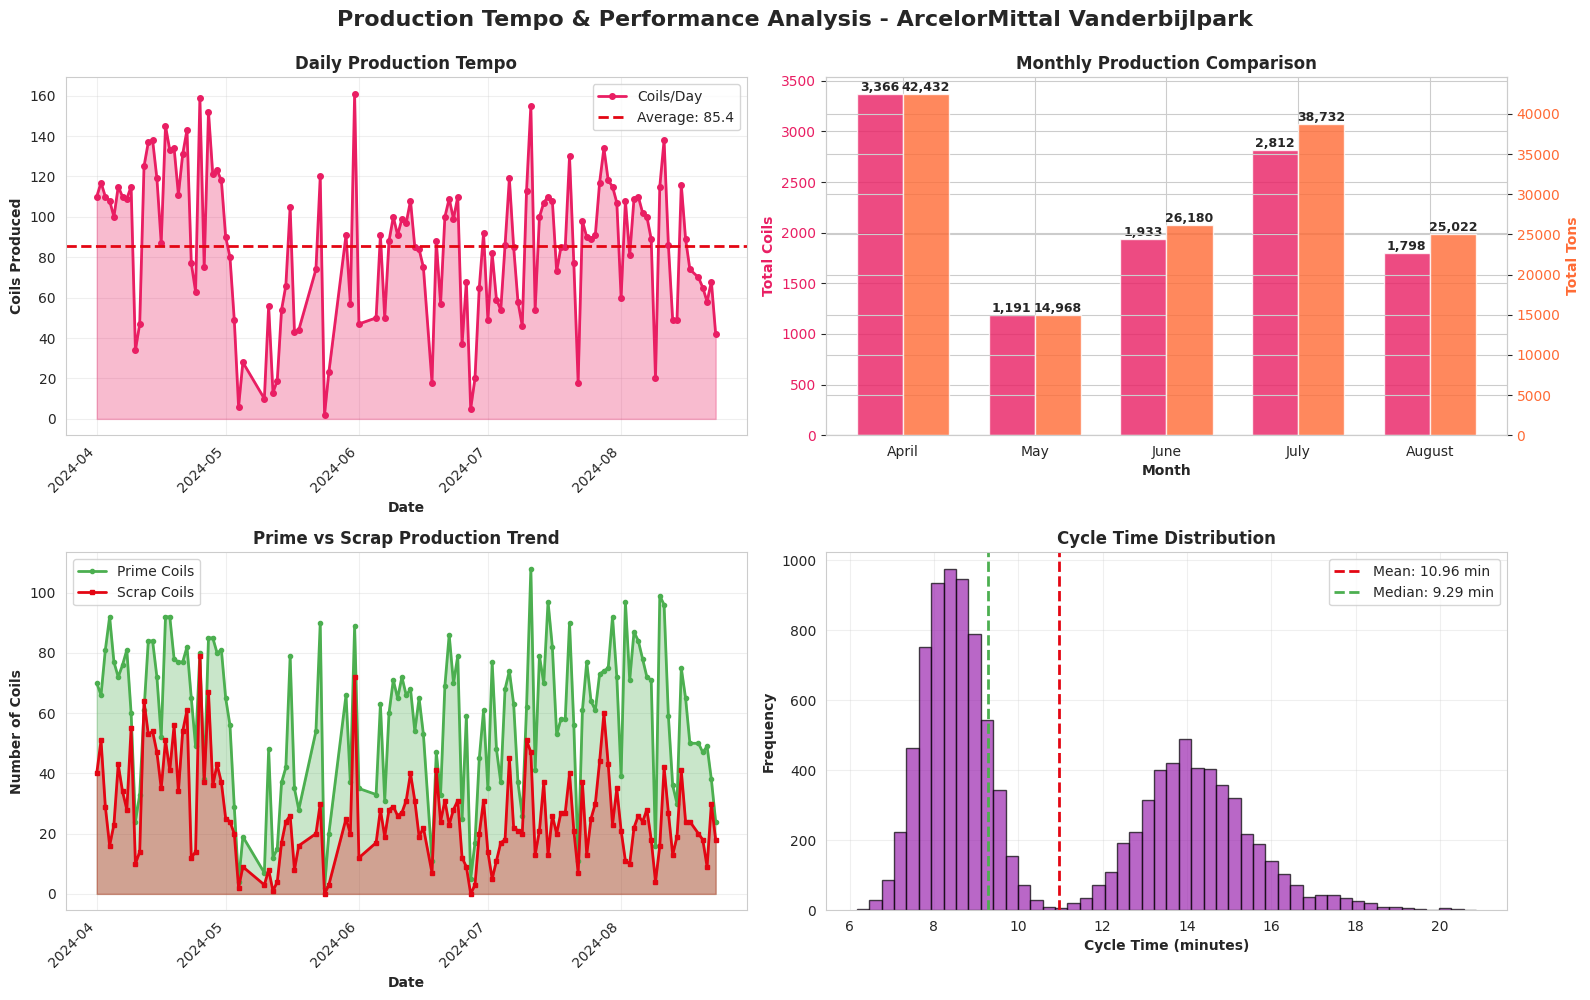

Figure 1: Production Tempo Analysis saved


In [47]:
# Figure 1: Production Tempo & Trends
fig1, axes = plt.subplots(2, 2, figsize=(16, 10))
fig1.suptitle('Production Tempo & Performance Analysis - ArcelorMittal Vanderbijlpark',
              fontsize=16, fontweight='bold', y=0.995)

# 1.1 Daily Production Trend
ax1 = axes[0, 0]
daily_production_plot = daily_production.copy()
ax1.plot(daily_production_plot['date'], daily_production_plot['total_coils'],
         marker='o', linewidth=2, markersize=4, color=am_colors['primary'], label='Coils/Day')
ax1.axhline(y=daily_production_plot['total_coils'].mean(), color=am_colors['alert'],
            linestyle='--', linewidth=2, label=f'Average: {daily_production_plot["total_coils"].mean():.1f}')
ax1.fill_between(daily_production_plot['date'], daily_production_plot['total_coils'],
                  alpha=0.3, color=am_colors['primary'])
ax1.set_xlabel('Date', fontweight='bold')
ax1.set_ylabel('Coils Produced', fontweight='bold')
ax1.set_title('Daily Production Tempo', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(True, alpha=0.3)
plt.setp(ax1.xaxis.get_majorticklabels(), rotation=45, ha='right')



# 1.2 Monthly Comparison
ax2 = axes[0, 1]
month_names = []
for _, row in monthly_production.iterrows():
    month_name = pd.to_datetime(f"{int(row['year'])}-{int(row['month'])}-01").strftime('%B')
    month_names.append(month_name)

monthly_coils = monthly_production['total_coils'].values
monthly_tons = monthly_production['total_tons'].values

x = np.arange(len(month_names))
width = 0.35

bars1 = ax2.bar(x - width/2, monthly_coils, width, label='Coils',
                color=am_colors['primary'], alpha=0.8)
ax2_twin = ax2.twinx()
bars2 = ax2_twin.bar(x + width/2, monthly_tons, width, label='Tons',
                      color=am_colors['secondary'], alpha=0.8)

ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Total Coils', fontweight='bold', color=am_colors['primary'])
ax2_twin.set_ylabel('Total Tons', fontweight='bold', color=am_colors['secondary'])
ax2.set_title('Monthly Production Comparison', fontweight='bold', fontsize=12)
ax2.set_xticks(x)
ax2.set_xticklabels(month_names)
ax2.tick_params(axis='y', labelcolor=am_colors['primary'])
ax2_twin.tick_params(axis='y', labelcolor=am_colors['secondary'])

# Add value labels
for bar in bars1:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax2_twin.text(bar.get_x() + bar.get_width()/2., height,
                  f'{int(height):,}',
                  ha='center', va='bottom', fontsize=9, fontweight='bold')


    # 1.3 Prime vs Scrap Analysis
ax3 = axes[1, 0]
prime_scrap_data = fact_production_coil.groupby('production_date').agg({
    'is_prime': 'sum',
    'is_scrap': 'sum'
}).reset_index()

ax3.plot(prime_scrap_data['production_date'], prime_scrap_data['is_prime'],
         label='Prime Coils', color=am_colors['success'], linewidth=2, marker='o', markersize=3)
ax3.plot(prime_scrap_data['production_date'], prime_scrap_data['is_scrap'],
         label='Scrap Coils', color=am_colors['alert'], linewidth=2, marker='s', markersize=3)
ax3.fill_between(prime_scrap_data['production_date'], prime_scrap_data['is_prime'],
                  alpha=0.3, color=am_colors['success'])
ax3.fill_between(prime_scrap_data['production_date'], prime_scrap_data['is_scrap'],
                  alpha=0.3, color=am_colors['alert'])
ax3.set_xlabel('Date', fontweight='bold')
ax3.set_ylabel('Number of Coils', fontweight='bold')
ax3.set_title('Prime vs Scrap Production Trend', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')


# 1.4 Cycle Time Distribution
ax4 = axes[1, 1]
cycle_times = fact_production_coil['total_cycle_time_min'].dropna()
ax4.hist(cycle_times, bins=50, color=am_colors['accent'], alpha=0.7, edgecolor='black')
ax4.axvline(cycle_times.mean(), color=am_colors['alert'], linestyle='--', linewidth=2,
            label=f'Mean: {cycle_times.mean():.2f} min')
ax4.axvline(cycle_times.median(), color=am_colors['success'], linestyle='--', linewidth=2,
            label=f'Median: {cycle_times.median():.2f} min')
ax4.set_xlabel('Cycle Time (minutes)', fontweight='bold')
ax4.set_ylabel('Frequency', fontweight='bold')
ax4.set_title('Cycle Time Distribution', fontweight='bold', fontsize=12)
ax4.legend()
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('production_tempo_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 1: Production Tempo Analysis saved")

## Section 11: Equipment Bottleneck Visualization

Visual identification of constraint equipment through time contribution analysis, bottleneck frequency heatmaps, and operation-queue time comparisons.

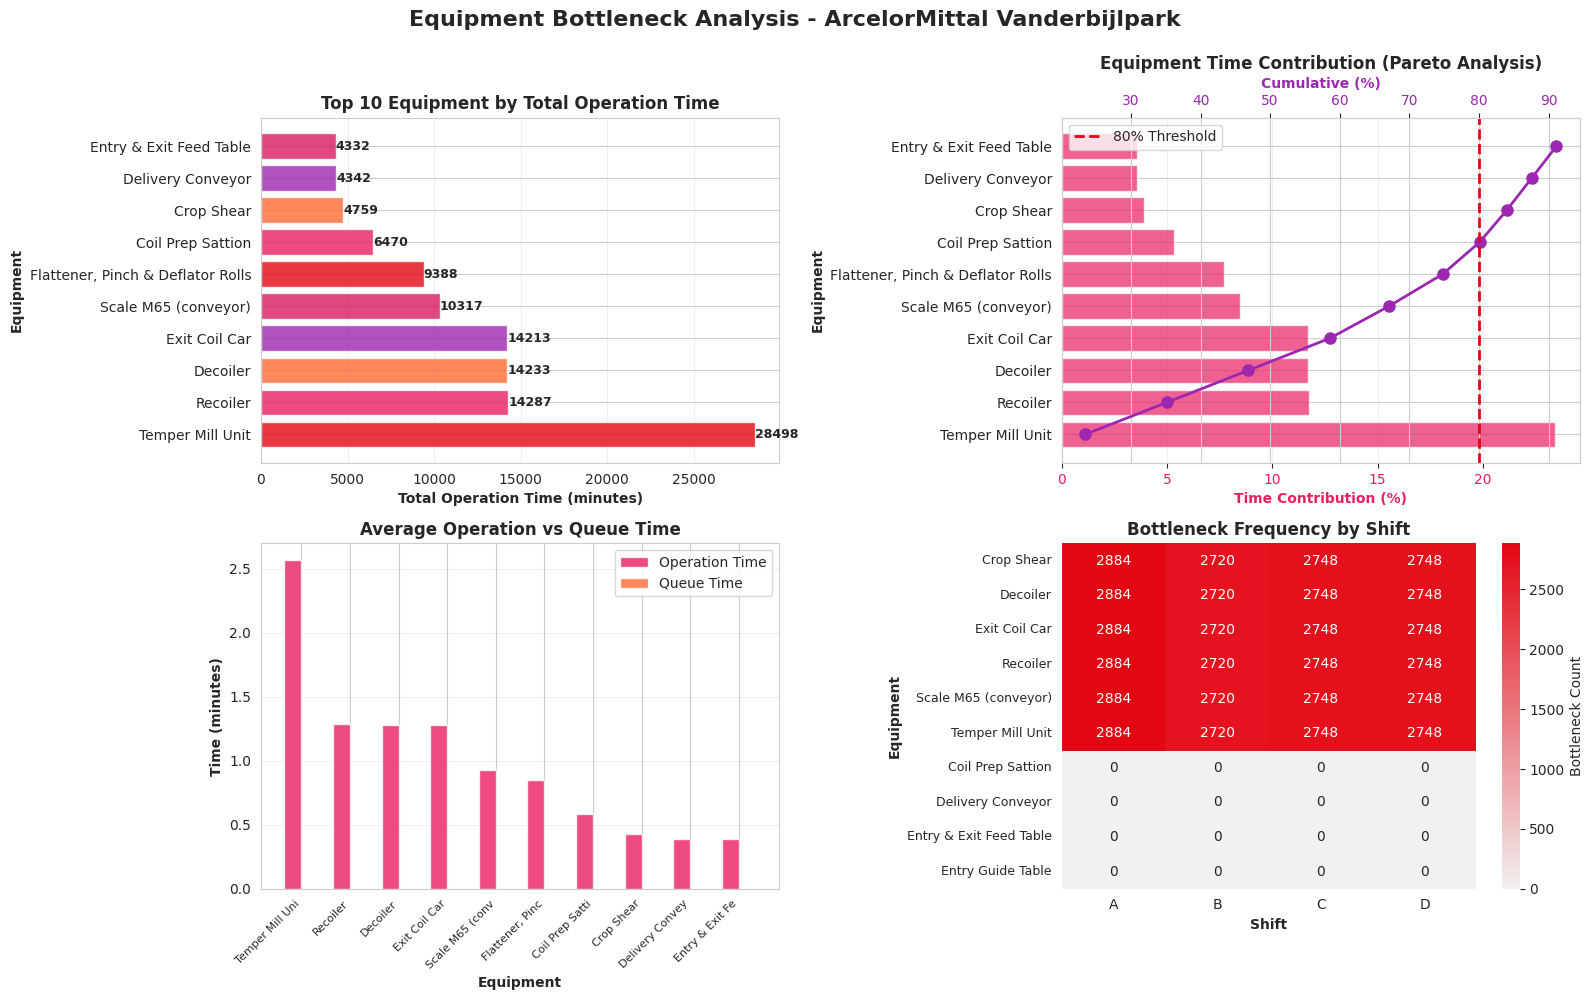

Figure 2: Bottleneck Analysis saved


In [48]:
# Figure 2: Bottleneck Analysis
fig2, axes = plt.subplots(2, 2, figsize=(16, 10))
fig2.suptitle('Equipment Bottleneck Analysis - ArcelorMittal Vanderbijlpark',
              fontsize=16, fontweight='bold', y=0.995)

# 2.1 Time Contribution by Equipment
ax1 = axes[0, 0]
top_time = equipment_performance.nlargest(10, 'total_operation_min')
colors = [am_colors['alert'], am_colors['primary'], am_colors['secondary'],
          am_colors['accent'], am_colors['deep']] * 2
bars = ax1.barh(top_time['equipment_name'], top_time['total_operation_min'],
                color=colors[:len(top_time)], alpha=0.8)
ax1.set_xlabel('Total Operation Time (minutes)', fontweight='bold')
ax1.set_ylabel('Equipment', fontweight='bold')
ax1.set_title('Top 10 Equipment by Total Operation Time', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

# Add time labels
for bar in bars:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
             f'{width:.0f}',
             ha='left', va='center', fontsize=9, fontweight='bold')

  # 2.2 Time Contribution Percentage (Pareto)
ax2 = axes[0, 1]
top_contrib = equipment_performance.nlargest(10, 'time_contribution_pct')
bars = ax2.barh(top_contrib['equipment_name'], top_contrib['time_contribution_pct'],
                color=am_colors['primary'], alpha=0.7)
ax2_twin = ax2.twiny()
ax2_twin.plot(top_contrib['cumulative_time_pct'], top_contrib['equipment_name'],
              marker='o', color=am_colors['accent'], linewidth=2, markersize=8)
ax2_twin.axvline(x=80, color=am_colors['alert'], linestyle='--', linewidth=2,
                 label='80% Threshold')

ax2.set_xlabel('Time Contribution (%)', fontweight='bold', color=am_colors['primary'])
ax2_twin.set_xlabel('Cumulative (%)', fontweight='bold', color=am_colors['accent'])
ax2.set_ylabel('Equipment', fontweight='bold')
ax2.set_title('Equipment Time Contribution (Pareto Analysis)', fontweight='bold', fontsize=12)
ax2.tick_params(axis='x', labelcolor=am_colors['primary'])
ax2_twin.tick_params(axis='x', labelcolor=am_colors['accent'])
ax2_twin.legend()
ax2.grid(True, alpha=0.3, axis='x')


# 2.3 Average Operation Time vs Queue Time
ax3 = axes[1, 0]
top_equip = equipment_performance.nlargest(10, 'avg_operation_min')
x = np.arange(len(top_equip))
width = 0.35

bars1 = ax3.bar(x - width/2, top_equip['avg_operation_min'], width,
                label='Operation Time', color=am_colors['primary'], alpha=0.8)
bars2 = ax3.bar(x + width/2, top_equip['avg_queue_min'], width,
                label='Queue Time', color=am_colors['secondary'], alpha=0.8)

ax3.set_xlabel('Equipment', fontweight='bold')
ax3.set_ylabel('Time (minutes)', fontweight='bold')
ax3.set_title('Average Operation vs Queue Time', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels([name[:15] for name in top_equip['equipment_name']],
                     rotation=45, ha='right', fontsize=8)
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')


# 2.4 Bottleneck Frequency Heatmap
ax4 = axes[1, 1]
bottleneck_data = fact_coil_operation_cycle.pivot_table(
    index='equipment_name',
    columns='shift_code',
    values='is_bottleneck_step',
    aggfunc='sum'
).fillna(0)

# Select top 10 equipment
top_10_bottleneck = bottleneck_data.sum(axis=1).nlargest(10).index
bottleneck_heatmap = bottleneck_data.loc[top_10_bottleneck]

sns.heatmap(bottleneck_heatmap, annot=True, fmt='.0f',
            cmap=sns.light_palette(am_colors['alert'], as_cmap=True),
            ax=ax4, cbar_kws={'label': 'Bottleneck Count'})
ax4.set_xlabel('Shift', fontweight='bold')
ax4.set_ylabel('Equipment', fontweight='bold')
ax4.set_title('Bottleneck Frequency by Shift', fontweight='bold', fontsize=12)
ax4.set_yticklabels(ax4.get_yticklabels(), rotation=0, fontsize=9)

plt.tight_layout()
plt.savefig('bottleneck_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2: Bottleneck Analysis saved")

## Section 12: Equipment Utilization Visualization

RUN/IDLE/FAULT state visualization reveals equipment availability, waiting patterns, and downtime distribution across the production line.

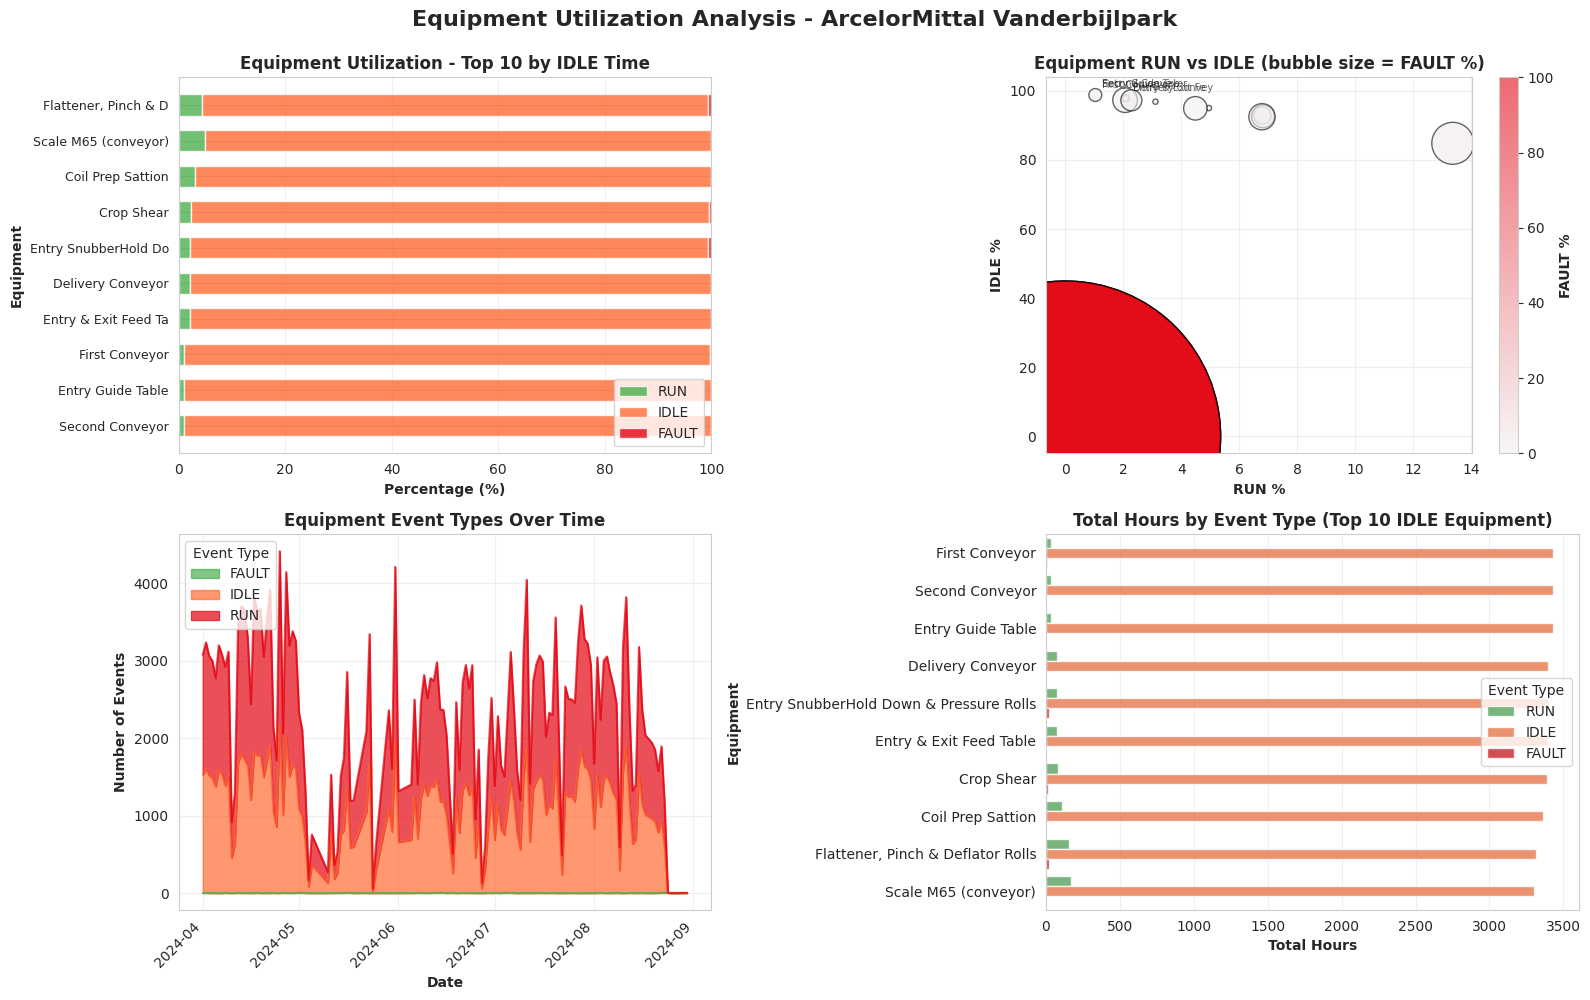

Figure 3: Equipment Utilization saved


In [49]:
# Figure 3: Equipment Utilization (RUN/IDLE/FAULT)
fig3, axes = plt.subplots(2, 2, figsize=(16, 10))
fig3.suptitle('Equipment Utilization Analysis - ArcelorMittal Vanderbijlpark',
              fontsize=16, fontweight='bold', y=0.995)

# 3.1 Equipment Utilization Stacked Bar
ax1 = axes[0, 0]
top_idle = equipment_pivot.nlargest(10, 'idle_pct')
equipment_names = [name[:20] for name in top_idle['equipment_name']]

x = np.arange(len(equipment_names))
width = 0.6

p1 = ax1.barh(x, top_idle['run_pct'], width, label='RUN',
              color=am_colors['success'], alpha=0.8)
p2 = ax1.barh(x, top_idle['idle_pct'], width, left=top_idle['run_pct'],
              label='IDLE', color=am_colors['secondary'], alpha=0.8)
p3 = ax1.barh(x, top_idle['fault_pct'], width,
              left=top_idle['run_pct'] + top_idle['idle_pct'],
              label='FAULT', color=am_colors['alert'], alpha=0.8)

ax1.set_yticks(x)
ax1.set_yticklabels(equipment_names, fontsize=9)
ax1.set_xlabel('Percentage (%)', fontweight='bold')
ax1.set_ylabel('Equipment', fontweight='bold')
ax1.set_title('Equipment Utilization - Top 10 by IDLE Time', fontweight='bold', fontsize=12)
ax1.legend(loc='lower right')
ax1.set_xlim(0, 100)
ax1.grid(True, alpha=0.3, axis='x')

# 3.2 RUN vs IDLE Scatter Plot
ax2 = axes[0, 1]
scatter = ax2.scatter(equipment_pivot['run_pct'], equipment_pivot['idle_pct'],
                     s=equipment_pivot['fault_pct']*500, alpha=0.6,
                     c=equipment_pivot['fault_pct'],
                     cmap=sns.light_palette(am_colors['alert'], as_cmap=True),
                     edgecolors='black', linewidth=1)
ax2.set_xlabel('RUN %', fontweight='bold')
ax2.set_ylabel('IDLE %', fontweight='bold')
ax2.set_title('Equipment RUN vs IDLE (bubble size = FAULT %)', fontweight='bold', fontsize=12)
ax2.grid(True, alpha=0.3)

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax2)
cbar.set_label('FAULT %', fontweight='bold')

# Annotate high idle equipment
high_idle = equipment_pivot.nlargest(5, 'idle_pct')
for idx, row in high_idle.iterrows():
    ax2.annotate(row['equipment_name'][:15],
                 (row['run_pct'], row['idle_pct']),
                 xytext=(5, 5), textcoords='offset points',
                 fontsize=7, alpha=0.7)

  # 3.3 Event Type Distribution Over Time
ax3 = axes[1, 0]
daily_events = fact_equipment_event_log.groupby(['event_date', 'event_type']).size().unstack(fill_value=0)

daily_events.plot(kind='area', stacked=True, ax=ax3, alpha=0.7,
                  color=[am_colors['success'], am_colors['secondary'], am_colors['alert']])
ax3.set_xlabel('Date', fontweight='bold')
ax3.set_ylabel('Number of Events', fontweight='bold')
ax3.set_title('Equipment Event Types Over Time', fontweight='bold', fontsize=12)
ax3.legend(title='Event Type', loc='upper left')
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')



# 3.4 Total Hours by Event Type
ax4 = axes[1, 1]
event_hours = equipment_pivot[['equipment_name', 'RUN', 'IDLE', 'FAULT']].copy()
event_hours = event_hours.nlargest(10, 'IDLE')

event_hours_melted = event_hours.melt(id_vars='equipment_name',
                                       value_vars=['RUN', 'IDLE', 'FAULT'],
                                       var_name='Event Type', value_name='Hours')

sns.barplot(data=event_hours_melted, x='Hours', y='equipment_name',
            hue='Event Type',
            palette=[am_colors['success'], am_colors['secondary'], am_colors['alert']],
            ax=ax4, alpha=0.8)
ax4.set_xlabel('Total Hours', fontweight='bold')
ax4.set_ylabel('Equipment', fontweight='bold')
ax4.set_title('Total Hours by Event Type (Top 10 IDLE Equipment)', fontweight='bold', fontsize=12)
ax4.legend(title='Event Type')
ax4.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('equipment_utilization.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 3: Equipment Utilization saved")

## Section 13: Maintenance Impact Visualization

Maintenance downtime distribution, category analysis, and temporal patterns identify reliability improvement opportunities and preventive maintenance priorities.

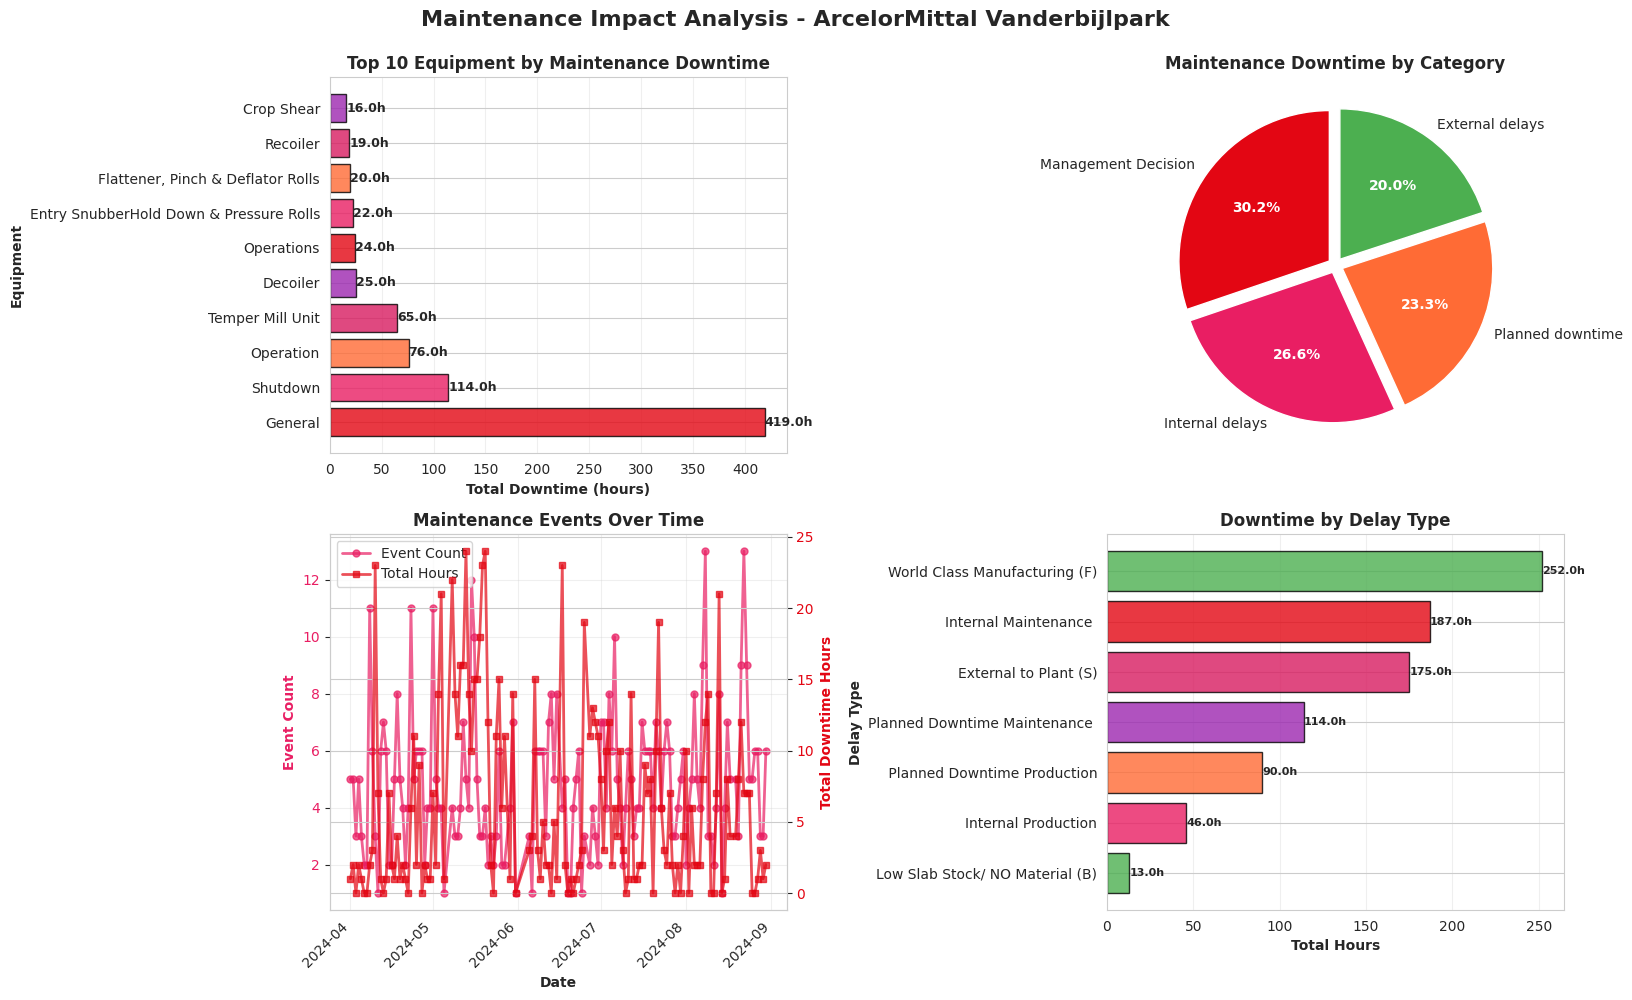

Figure 4: Maintenance Analysis saved


In [50]:
# Figure 4: Maintenance Impact Analysis
fig4, axes = plt.subplots(2, 2, figsize=(16, 10))
fig4.suptitle('Maintenance Impact Analysis - ArcelorMittal Vanderbijlpark',
              fontsize=16, fontweight='bold', y=0.995)

# 4.1 Top Equipment by Maintenance Downtime
ax1 = axes[0, 0]
top_maintenance = maintenance_by_equipment.head(10)
colors_maint = [am_colors['alert'], am_colors['primary'], am_colors['secondary'],
                am_colors['deep'], am_colors['accent']] * 2
bars = ax1.barh(top_maintenance['equipment_name'],
                top_maintenance['total_downtime_hours'],
                color=colors_maint[:len(top_maintenance)], alpha=0.8,
                edgecolor='black', linewidth=1)
ax1.set_xlabel('Total Downtime (hours)', fontweight='bold')
ax1.set_ylabel('Equipment', fontweight='bold')
ax1.set_title('Top 10 Equipment by Maintenance Downtime', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

for bar in bars:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
             f'{width:.1f}h', ha='left', va='center', fontsize=9, fontweight='bold')

# 4.2 Maintenance by Category
ax2 = axes[0, 1]
category_data = maintenance_by_category.copy()
colors_cat = [am_colors['alert'], am_colors['primary'], am_colors['secondary'], am_colors['success']]
wedges, texts, autotexts = ax2.pie(category_data['total_hours'],
                                     labels=category_data['category'],
                                     autopct='%1.1f%%',
                                     startangle=90,
                                     colors=colors_cat,
                                     explode=[0.05] * len(category_data))
ax2.set_title('Maintenance Downtime by Category', fontweight='bold', fontsize=12)

for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_fontweight('bold')

# 4.3 Maintenance Events Over Time
ax3 = axes[1, 0]
fact_maintenance_event['event_date'] = pd.to_datetime(fact_maintenance_event['start_datetime']).dt.date
daily_maintenance = fact_maintenance_event.groupby('event_date').agg({
    'duration_hours': 'sum',
    'equipment_name': 'count'
}).reset_index()
daily_maintenance.columns = ['date', 'total_hours', 'event_count']
daily_maintenance['date'] = pd.to_datetime(daily_maintenance['date'])

ax3_twin = ax3.twinx()

line1 = ax3.plot(daily_maintenance['date'], daily_maintenance['event_count'],
                 marker='o', linewidth=2, markersize=5, color=am_colors['primary'],
                 label='Event Count', alpha=0.7)
line2 = ax3_twin.plot(daily_maintenance['date'], daily_maintenance['total_hours'],
                      marker='s', linewidth=2, markersize=5, color=am_colors['alert'],
                      label='Total Hours', alpha=0.7)

ax3.set_xlabel('Date', fontweight='bold')
ax3.set_ylabel('Event Count', fontweight='bold', color=am_colors['primary'])
ax3_twin.set_ylabel('Total Downtime Hours', fontweight='bold', color=am_colors['alert'])
ax3.set_title('Maintenance Events Over Time', fontweight='bold', fontsize=12)
ax3.tick_params(axis='y', labelcolor=am_colors['primary'])
ax3_twin.tick_params(axis='y', labelcolor=am_colors['alert'])
ax3.grid(True, alpha=0.3)
plt.setp(ax3.xaxis.get_majorticklabels(), rotation=45, ha='right')

lines = line1 + line2
labels = [l.get_label() for l in lines]
ax3.legend(lines, labels, loc='upper left')

# 4.4 Downtime by Delay Type
ax4 = axes[1, 1]
if 'Delay Type' in fact_maintenance_event.columns:
    delay_type_summary_clean = fact_maintenance_event.groupby('Delay Type').agg({
        'duration_hours': ['sum', 'count']
    }).reset_index()
    delay_type_summary_clean.columns = ['delay_type', 'total_hours', 'event_count']
    delay_type_summary_clean = delay_type_summary_clean.sort_values('total_hours', ascending=True)

    colors_delay = [am_colors['success'], am_colors['primary'], am_colors['secondary'],
                    am_colors['accent'], am_colors['deep'], am_colors['alert']] * 2
    bars = ax4.barh(delay_type_summary_clean['delay_type'],
                    delay_type_summary_clean['total_hours'],
                    color=colors_delay[:len(delay_type_summary_clean)],
                    alpha=0.8, edgecolor='black', linewidth=1)
    ax4.set_xlabel('Total Hours', fontweight='bold')
    ax4.set_ylabel('Delay Type', fontweight='bold')
    ax4.set_title('Downtime by Delay Type', fontweight='bold', fontsize=12)
    ax4.grid(True, alpha=0.3, axis='x')

    for bar in bars:
        width = bar.get_width()
        ax4.text(width, bar.get_y() + bar.get_height()/2.,
                 f'{width:.1f}h',
                 ha='left', va='center', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('maintenance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 4: Maintenance Analysis saved")

## Section 14: Shift Performance Visualization

Crew productivity comparison, quality metrics by shift, and transition gap analysis identify training opportunities and operational best practices for knowledge transfer.

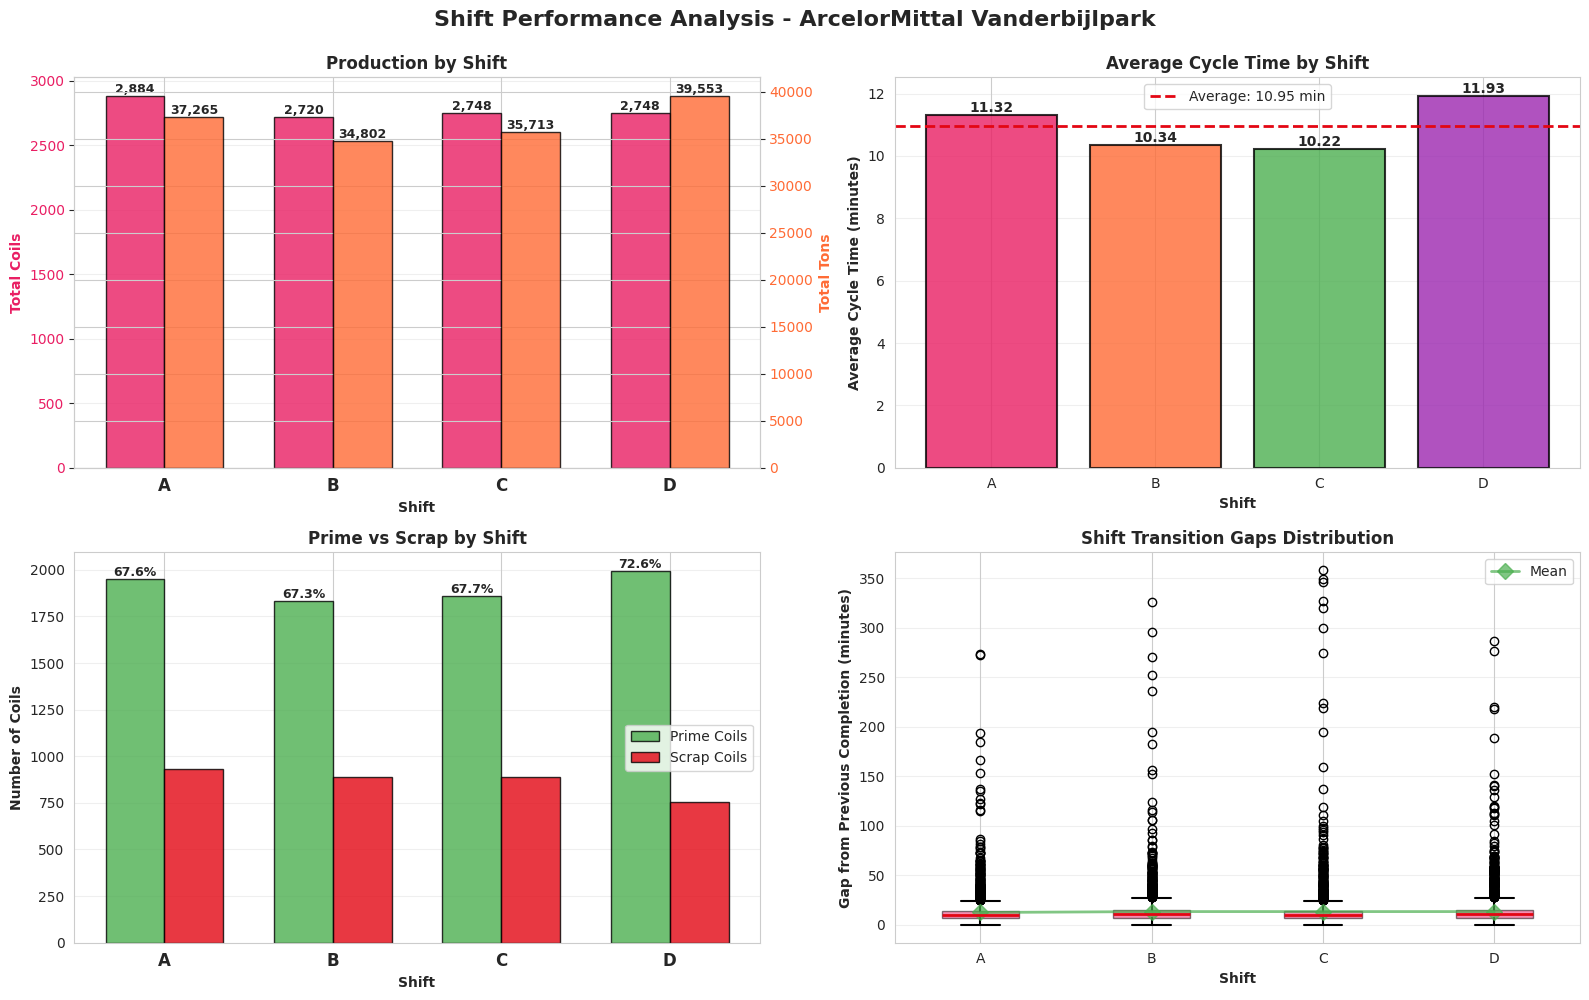

Figure 5: Shift Performance Analysis saved


In [51]:
# Figure 5: Shift Performance Analysis
fig5, axes = plt.subplots(2, 2, figsize=(16, 10))
fig5.suptitle('Shift Performance Analysis - ArcelorMittal Vanderbijlpark',
              fontsize=16, fontweight='bold', y=0.995)

# 5.1 Production by Shift
ax1 = axes[0, 0]
shifts = shift_performance['shift'].values
x = np.arange(len(shifts))
width = 0.35

bars1 = ax1.bar(x - width/2, shift_performance['total_coils'], width,
                label='Total Coils', color=am_colors['primary'], alpha=0.8,
                edgecolor='black', linewidth=1)
ax1_twin = ax1.twinx()
bars2 = ax1_twin.bar(x + width/2, shift_performance['total_tons'], width,
                     label='Total Tons', color=am_colors['secondary'], alpha=0.8,
                     edgecolor='black', linewidth=1)

ax1.set_xlabel('Shift', fontweight='bold')
ax1.set_ylabel('Total Coils', fontweight='bold', color=am_colors['primary'])
ax1_twin.set_ylabel('Total Tons', fontweight='bold', color=am_colors['secondary'])
ax1.set_title('Production by Shift', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(shifts, fontsize=12, fontweight='bold')
ax1.tick_params(axis='y', labelcolor=am_colors['primary'])
ax1_twin.tick_params(axis='y', labelcolor=am_colors['secondary'])
ax1.grid(True, alpha=0.3, axis='y')

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height):,}',
            ha='center', va='bottom', fontsize=9, fontweight='bold')

for bar in bars2:
    height = bar.get_height()
    ax1_twin.text(bar.get_x() + bar.get_width()/2., height,
                  f'{int(height):,}',
                  ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5.2 Average Cycle Time by Shift
ax2 = axes[0, 1]
colors_shift = [am_colors['primary'], am_colors['secondary'],
                am_colors['success'], am_colors['accent']]
bars = ax2.bar(shift_performance['shift'], shift_performance['avg_cycle_time'],
               color=colors_shift, alpha=0.8, edgecolor='black', linewidth=1.5)
ax2.axhline(y=shift_performance['avg_cycle_time'].mean(), color=am_colors['alert'],
            linestyle='--', linewidth=2,
            label=f'Average: {shift_performance["avg_cycle_time"].mean():.2f} min')
ax2.set_xlabel('Shift', fontweight='bold')
ax2.set_ylabel('Average Cycle Time (minutes)', fontweight='bold')
ax2.set_title('Average Cycle Time by Shift', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5.3 Prime vs Scrap by Shift
ax3 = axes[1, 0]
x = np.arange(len(shifts))
width = 0.35

bars1 = ax3.bar(x - width/2, shift_performance['prime_coils'], width,
                label='Prime Coils', color=am_colors['success'], alpha=0.8,
                edgecolor='black', linewidth=1)
bars2 = ax3.bar(x + width/2, shift_performance['scrap_coils'], width,
                label='Scrap Coils', color=am_colors['alert'], alpha=0.8,
                edgecolor='black', linewidth=1)

ax3.set_xlabel('Shift', fontweight='bold')
ax3.set_ylabel('Number of Coils', fontweight='bold')
ax3.set_title('Prime vs Scrap by Shift', fontweight='bold', fontsize=12)
ax3.set_xticks(x)
ax3.set_xticklabels(shifts, fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3, axis='y')

for i, (bar1, bar2) in enumerate(zip(bars1, bars2)):
    total = bar1.get_height() + bar2.get_height()
    prime_pct = (bar1.get_height() / total) * 100
    ax3.text(bar1.get_x() + bar1.get_width()/2., bar1.get_height(),
             f'{prime_pct:.1f}%',
             ha='center', va='bottom', fontsize=9, fontweight='bold')

# 5.4 Shift Transition Gaps
ax4 = axes[1, 1]
avg_gap_by_shift_reset = avg_gap_by_shift.reset_index()
shifts_gap = avg_gap_by_shift_reset['shift_code'].values

shift_gap_data = []
for shift in shifts_gap:
    gaps = shift_transitions[shift_transitions['shift_code'] == shift]['gap_from_prev_completion_min'].dropna()
    shift_gap_data.append(gaps)

bp = ax4.boxplot(shift_gap_data, labels=shifts_gap, patch_artist=True,
                 boxprops=dict(facecolor=am_colors['primary'], alpha=0.5),
                 medianprops=dict(color=am_colors['alert'], linewidth=2),
                 whiskerprops=dict(linewidth=1.5),
                 capprops=dict(linewidth=1.5))

ax4.set_xlabel('Shift', fontweight='bold')
ax4.set_ylabel('Gap from Previous Completion (minutes)', fontweight='bold')
ax4.set_title('Shift Transition Gaps Distribution', fontweight='bold', fontsize=12)
ax4.grid(True, alpha=0.3, axis='y')

means = [gaps.mean() for gaps in shift_gap_data]
ax4.plot(range(1, len(means) + 1), means, 'D-', color=am_colors['success'],
         linewidth=2, markersize=8, label='Mean', alpha=0.7)
ax4.legend()

plt.tight_layout()
plt.savefig('shift_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 5: Shift Performance Analysis saved")

## Section 15: Product Mix Visualization

Product grade distribution, thickness-cycle time relationships, and prime/scrap patterns reveal product-specific optimization opportunities and quality improvement targets.

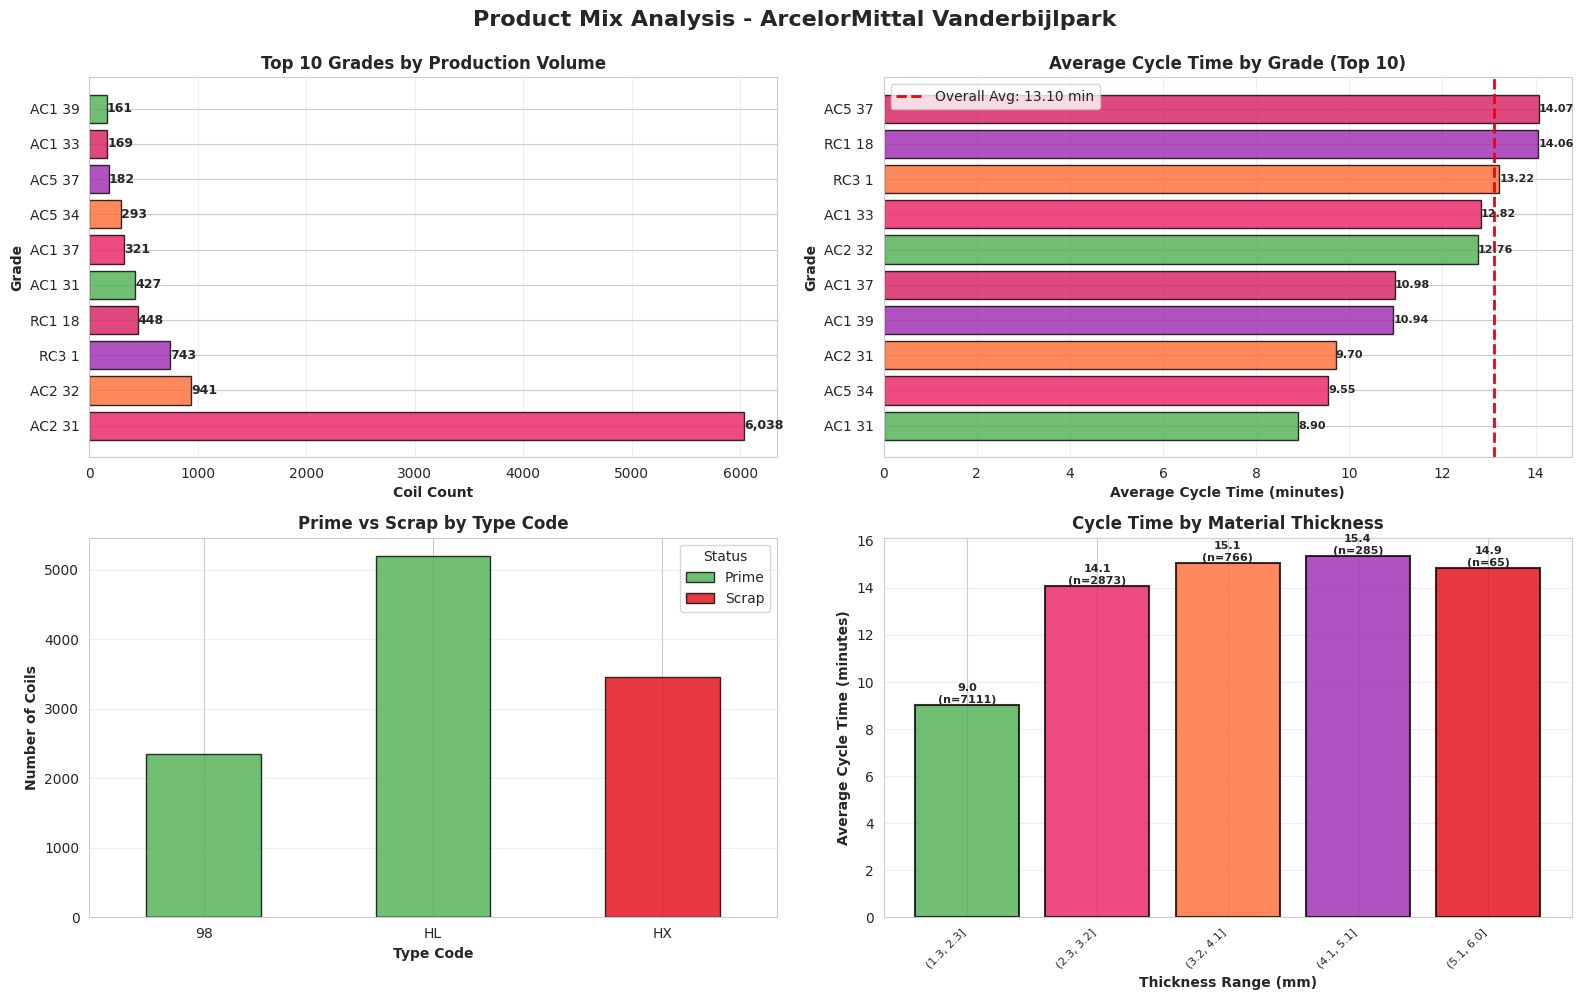

Figure 6: Product Mix Analysis saved


In [52]:
# Figure 6: Product Mix Analysis
fig6, axes = plt.subplots(2, 2, figsize=(16, 10))
fig6.suptitle('Product Mix Analysis - ArcelorMittal Vanderbijlpark',
              fontsize=16, fontweight='bold', y=0.995)

# 6.1 Production by Grade (Top 10)
ax1 = axes[0, 0]
top_grades = grade_summary.head(10)
colors_grade = [am_colors['primary'], am_colors['secondary'], am_colors['accent'],
                am_colors['deep'], am_colors['success']] * 2
bars = ax1.barh(top_grades['grade'], top_grades['coil_count'],
                color=colors_grade[:len(top_grades)], alpha=0.8,
                edgecolor='black', linewidth=1)
ax1.set_xlabel('Coil Count', fontweight='bold')
ax1.set_ylabel('Grade', fontweight='bold')
ax1.set_title('Top 10 Grades by Production Volume', fontweight='bold', fontsize=12)
ax1.grid(True, alpha=0.3, axis='x')

for bar in bars:
    width = bar.get_width()
    ax1.text(width, bar.get_y() + bar.get_height()/2.,
             f'{int(width):,}', ha='left', va='center', fontsize=9, fontweight='bold')

# 6.2 Cycle Time by Grade (Top 10)
ax2 = axes[0, 1]
top_grades_cycle = grade_summary.head(10).sort_values('avg_cycle_time', ascending=True)
colors_cycle = [am_colors['success'], am_colors['primary'], am_colors['secondary'],
                am_colors['accent'], am_colors['deep']] * 2
bars = ax2.barh(top_grades_cycle['grade'], top_grades_cycle['avg_cycle_time'],
                color=colors_cycle[:len(top_grades_cycle)], alpha=0.8,
                edgecolor='black', linewidth=1)
ax2.axvline(x=grade_summary['avg_cycle_time'].mean(), color=am_colors['alert'],
            linestyle='--', linewidth=2,
            label=f'Overall Avg: {grade_summary["avg_cycle_time"].mean():.2f} min')
ax2.set_xlabel('Average Cycle Time (minutes)', fontweight='bold')
ax2.set_ylabel('Grade', fontweight='bold')
ax2.set_title('Average Cycle Time by Grade (Top 10)', fontweight='bold', fontsize=12)
ax2.legend()
ax2.grid(True, alpha=0.3, axis='x')

for bar in bars:
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2.,
             f'{width:.2f}', ha='left', va='center', fontsize=8, fontweight='bold')

# 6.3 Prime vs Scrap Production (Stacked Bar)
ax3 = axes[1, 0]
type_codes = ['HL', 'HX', '98']
prime_scrap_filtered = prime_scrap_summary[prime_scrap_summary['type_code'].isin(type_codes)]

pivot_data = prime_scrap_filtered.pivot_table(
    index='type_code',
    columns='is_prime',
    values='coil_count',
    aggfunc='sum'
).fillna(0)

if len(pivot_data.columns) == 2:
    pivot_data.columns = ['Scrap', 'Prime']
    pivot_data = pivot_data[['Prime', 'Scrap']]

    pivot_data.plot(kind='bar', stacked=True, ax=ax3,
                    color=[am_colors['success'], am_colors['alert']],
                    alpha=0.8, edgecolor='black', linewidth=1)
    ax3.set_xlabel('Type Code', fontweight='bold')
    ax3.set_ylabel('Number of Coils', fontweight='bold')
    ax3.set_title('Prime vs Scrap by Type Code', fontweight='bold', fontsize=12)
    ax3.legend(title='Status')
    ax3.grid(True, alpha=0.3, axis='y')
    plt.setp(ax3.xaxis.get_majorticklabels(), rotation=0)

# 6.4 Cycle Time by Thickness
ax4 = axes[1, 1]
thickness_cycle_data = fact_production_coil.copy()
thickness_cycle_data['thickness_bin'] = pd.cut(thickness_cycle_data['thickness_mm'],
                                                bins=5, precision=1)
thickness_agg = thickness_cycle_data.groupby('thickness_bin')['total_cycle_time_min'].agg(['mean', 'count'])
thickness_agg = thickness_agg.reset_index()

thickness_agg['thickness_label'] = thickness_agg['thickness_bin'].astype(str)
thickness_agg = thickness_agg.dropna()

colors_thick = [am_colors['success'], am_colors['primary'], am_colors['secondary'],
                am_colors['accent'], am_colors['alert']]
bars = ax4.bar(range(len(thickness_agg)), thickness_agg['mean'],
               color=colors_thick[:len(thickness_agg)], alpha=0.8,
               edgecolor='black', linewidth=1.5)
ax4.set_xlabel('Thickness Range (mm)', fontweight='bold')
ax4.set_ylabel('Average Cycle Time (minutes)', fontweight='bold')
ax4.set_title('Cycle Time by Material Thickness', fontweight='bold', fontsize=12)
ax4.set_xticks(range(len(thickness_agg)))
ax4.set_xticklabels([f"{t}" for t in thickness_agg['thickness_label']],
                     rotation=45, ha='right', fontsize=8)
ax4.grid(True, alpha=0.3, axis='y')

for i, (bar, count) in enumerate(zip(bars, thickness_agg['count'])):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}\n(n={int(count)})',
             ha='center', va='bottom', fontsize=8, fontweight='bold')

plt.tight_layout()
plt.savefig('product_mix_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 6: Product Mix Analysis saved")